# Setup

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [3]:
''' Define plotting defaults '''

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [5]:
''' Complete List of Mice & Neural Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_1 excluded, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [6]:
'''Define which mice & sessions to load based on metadata'''
# Define mice, sessions for particular cohorts
mice , mice_ind, _  = np.intersect1d(all_mice,(np.union1d(cohorta_mice, cohortb_mice)), return_indices = True) # RF mice 

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

# Edit these paths

In [7]:
#Inputs
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # adjust path to match output of Import & Filter
shuffload_folder1 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/sparsity/' # adjust to match location of this Dryad repo folder
shuffload_folder2 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/coherence/' # adjust to match location of this Dryad repo folder
fig2s3_folder = 'C:/Users/Python/Desktop/LocalData/Figure2S3/' # adjust to match Figure 2/S3 output folder
fig3s4_folder = 'C:/Users/Python/Desktop/LocalData/Figure3S4/' # adjust to match Figure 3/S4 output folder
int_save_folder = 'C:/Users/Python/Desktop/LocalData/FigureS6/' # adjust to match Shuffle Procedure output plotsave_folder

#Output (create folder to hold the output of this notebook; then match the name of this repository below)
save_folder = 'C:/Users/Python/Desktop/LocalData/Figure5/' 

In [8]:
''' Total Number of RF Cells'''

young_count = 0
age_count = 0

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        if m in RF_aged_mice:
            age_count += len(cell_IDs)
        else:
            young_count += len(cell_IDs)
            
print(young_count, age_count)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

10590 10338


# Classify spatial cells using shuffle results OR skip to the next section.

You'll only need to run this section only once in order to generate spatial cell booleans for these sessions.

In [9]:
''' Calculate Spatial Firing Sparsity & Coherence Scores for RF Cells 

OR if you have already run the Figure 5 code, skip to the next cell and load 
these scores.

'''
sparsity_scores = []
spatialcoherence_scores = []
dt = 0.02

for m, session in zip(mice, sessions):
    for s in tdqm(session, leave=False):
        d = data[m][s]
        
        #get data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

        cell_IDs = raw.item().get('cellsfil')
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        post = behaviorfil[:,3]
        
        #get smoothed FR & sparsity scores
        smoothFR, centers, smoothocc = ps.tuning_curve(posx, Y, dt, b = 2, l=2, smooth=True, SEM=False, occupancy=True)
        total_time = max(post) - min(post)
        
        sparsity_scores = []
        for i, c in enumerate(cell_IDs):
            meanFRsqr = np.square(np.mean(smoothFR[:,i]))
            products = []
            sparsity = []
            for b in range(smoothFR.shape[0]):
                binmeanFRsqr = np.square(smoothFR[b,i])
                prob = smoothocc[b,i]/total_time
                prod = prob * binmeanFRsqr
                products = np.append(products,prod)
            sparsity = np.sum(products) / meanFRsqr
            sparsity_scores = np.append(sparsity_scores,sparsity)    
        d['sparsityscores'] = sparsity_scores 
        
        #get non-smoothed FR & spatial coherence scores 
        FR, centers, occ = ps.tuning_curve(posx, Y, dt, b = 2, l=2, smooth=False, SEM=False, occupancy=True)
        
        spatialcoherence_scores = []
        for i, c in enumerate(cell_IDs):
            neighbors = get.find8adjacentElements(FR[:,i])
            meanFR_neighbors = []
            for b in range(FR.shape[0]):
                meanFR_neigh = np.mean(neighbors[b])
                meanFR_neighbors = np.append(meanFR_neighbors, meanFR_neigh)
            coherence, p = stats.pearsonr(FR[:,i],meanFR_neighbors)
            if math.isnan(coherence):
                spatialcoherence_scores = np.append(spatialcoherence_scores,0)
            else:
                spatialcoherence_scores = np.append(spatialcoherence_scores,coherence)
        d['spatialcoherencescores'] = spatialcoherence_scores
    
        #Get file names & save scores as npy files
        sparsityscore_file = 'sparsityscores_' + m + '_' + s + '.npy'
        spatialcoherencescore_file = 'spatialcoherencescores_' + m + '_' + s + '.npy'

        np.save(save_folder + sparsityscore_file, sparsity_scores)
        #print('saved sparsity scores as npy file for mouse ' + m + ' session '+ s)

        np.save(save_folder + spatialcoherencescore_file, spatialcoherence_scores)
        #print('saved spatial coherence scores as npy file for mouse ' + m + ' session '+ s)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
''' Load saved scores to classify spatial cells or use the ones you just generated above

Note : intn boolean & shuffled scores are produced by the notebook "Shuffle Procedure...." Please run that for all sessions 
before proceeding here or use saved scores in Dryad repository.
'''

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get file names
        shufsparsityscore_file = 'shufsparsityscores_' + m + '_' + s + '.npy'
        shufspatialcoherencescore_file = 'shufspatialcoherencescores_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        #load npy files       

        d['shuffsparsityscores'] = np.load(shuffload_folder1 + shufsparsityscore_file, allow_pickle=False)
        d['shuffspatialcoherencescores'] = np.load(shuffload_folder2 + shufspatialcoherencescore_file, allow_pickle=False)
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
        d['intn'] = d['intn'].astype(bool)

        
        try:
            _ = d['sparsityscores'].shape
        except:
            print('loading previously generated sparsity & coherence scores...')
            sparsityscore_file = 'sparsityscores_' + m + '_' + s + '.npy'
            spatialcoherencescore_file = 'spatialcoherencescores_' + m + '_' + s + '.npy'
            
            d['sparsityscores'] = np.load(save_folder + sparsityscore_file, allow_pickle=True)
            d['spatialcoherencescores'] = np.load(save_folder + spatialcoherencescore_file, allow_pickle=True)

  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/5 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/3 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/5 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/5 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/2 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


In [10]:
''' Classify Spatial Cells from all Sessions: 

Note : shuffled scores are produced by the notebook "Shuffle Procedure." 
Please run that for all sessions before proceeding here.

'''
per99c = []
per99s = []
dt = 0.02

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        sparsity_scores = d['sparsityscores']
        spatialcoherence_scores = d['spatialcoherencescores']
        shuffsparsityscores = d['shuffsparsityscores']
        shuffspatialcoherencescores = d['shuffspatialcoherencescores'] 
        intn = d['intn'].astype(bool)

        #Classify spatial cells as those >P95, >P99 of both sparsity & coherence distributions
        spatialcell99 = []
        spatialcells99 = []
    
        for i, c in enumerate(cell_IDs):
            dist1 = shuffspatialcoherencescores[:,i]
            P991 = np.percentile(dist1,99)

            dist2 = shuffsparsityscores[:,i]
            P992 = np.percentile(dist2,99)
            
            per99c.append(P991)
            per99s.append(P992)

            if intn[i] == True:
                spatialcell99 = np.append(spatialcell99, False)
            elif (spatialcoherence_scores[i] > P991) & (sparsity_scores[i] > P992):
                spatialcell99 = np.append(spatialcell99, True)
            else:
                spatialcell99 = np.append(spatialcell99, False)

        spatialcell99 = np.asarray(spatialcell99).astype(bool)
        
        d['spatialcells99'] = cell_IDs[spatialcell99]
        d['spatialcell99'] = spatialcell99
        
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        np.save(save_folder + spatialcell99_file, spatialcell99)
        #print('saved spatial cell booleans as npy files for mouse ' + m + ' session '+ s)

print('\nMean ± SEM Coherence P99: ' + str(np.mean(per99c)) + ' ± ' + str(stats.sem(per99c)))  
print('\nMean ± SEM Sparsity P99: ' + str(np.nanmean(per99s)) + ' ± ' + str(stats.sem(per99s,  nan_policy = 'omit'))) 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]


Mean ± SEM Coherence P99: 0.44397451511927966 ± 0.001023052553156076

Mean ± SEM Sparsity P99: 0.8021158854819103 ± 0.0022493857825195036


In [11]:
''' Check out distribution of spatial cells '''

per99 = []
sper99 = []
mper99 = []

for m, session in zip(mice,sessions):
    
    m_99 = []
    m_cells = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        #load all spatial cell boolean
        spatialcell = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell]
        
        print(m + ', ' + s + ' n spatial cells: '+ str(np.sum(spatialcell)))
        per99 = np.append(per99, 100*np.sum(spatialcell)/len(cell_IDs))
        sper99 = np.append(sper99, 100*np.sum(spatialcell)/len(cell_IDs))
        m_99 = np.append(m_99, np.sum(spatialcell))
        m_cells = np.append(m_cells, len(cell_IDs))
        
    mper99 = np.append(mper99, np.sum(m_99)/np.sum(m_cells))

  0%|          | 0/6 [00:00<?, ?it/s]

A12, 051822_record1 n spatial cells: 86
A12, 051922_record2 n spatial cells: 241
A12, 052022_record3 n spatial cells: 128
A12, 052122_record4 n spatial cells: 62
A12, 052222_record5 n spatial cells: 93
A12, 052322_record6 n spatial cells: 32


  0%|          | 0/6 [00:00<?, ?it/s]

A13, 050522_record1 n spatial cells: 96
A13, 050622_record2 n spatial cells: 297
A13, 050722_record3 n spatial cells: 269
A13, 050822_record4 n spatial cells: 92
A13, 050922_record5 n spatial cells: 26
A13, 051022_record6 n spatial cells: 116


  0%|          | 0/6 [00:00<?, ?it/s]

A3, 0122_record1 n spatial cells: 17
A3, 0123_record2 n spatial cells: 7
A3, 0124_record3 n spatial cells: 15
A3, 0125_record4 n spatial cells: 86
A3, 0126_record5 n spatial cells: 5
A3, 0127_record6 n spatial cells: 29


  0%|          | 0/6 [00:00<?, ?it/s]

A4, 0122_record1 n spatial cells: 71
A4, 0123_record2 n spatial cells: 56
A4, 0124_record3 n spatial cells: 69
A4, 0125_record4 n spatial cells: 139
A4, 0126_record5 n spatial cells: 179
A4, 0127_record6 n spatial cells: 44


  0%|          | 0/6 [00:00<?, ?it/s]

A5, 0401_record1 n spatial cells: 20
A5, 0401_record2b n spatial cells: 81
A5, 0403_record3 n spatial cells: 67
A5, 0404_record4 n spatial cells: 99
A5, 0405_record5 n spatial cells: 16
A5, 0406_record6 n spatial cells: 19


  0%|          | 0/6 [00:00<?, ?it/s]

A6, 0401_record1 n spatial cells: 72
A6, 0402_record2 n spatial cells: 10
A6, 0403_record3 n spatial cells: 19
A6, 0404_record4 n spatial cells: 60
A6, 0405_record5 n spatial cells: 68
A6, 0406_record6 n spatial cells: 44


  0%|          | 0/6 [00:00<?, ?it/s]

A7, 0414_record1 n spatial cells: 82
A7, 0415_record2 n spatial cells: 147
A7, 0416_record3 n spatial cells: 153
A7, 0417_record4 n spatial cells: 158
A7, 0418_record5 n spatial cells: 103
A7, 0419_record6 n spatial cells: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Y11, 050522_record1 n spatial cells: 52
Y11, 050622_record2 n spatial cells: 146
Y11, 050722_record3 n spatial cells: 274
Y11, 050822_record4 n spatial cells: 51
Y11, 051022_record6 n spatial cells: 125


  0%|          | 0/3 [00:00<?, ?it/s]

Y16, 062222_record3 n spatial cells: 54
Y16, 062322_record4 n spatial cells: 6
Y16, 062522_record5 n spatial cells: 1


  0%|          | 0/6 [00:00<?, ?it/s]

Y17, 062822_record1 n spatial cells: 59
Y17, 062922_record2 n spatial cells: 111
Y17, 063022_record3 n spatial cells: 63
Y17, 070122_record4 n spatial cells: 245
Y17, 070222_record5 n spatial cells: 214
Y17, 070322_record6 n spatial cells: 177


  0%|          | 0/6 [00:00<?, ?it/s]

Y18, 062022_record1 n spatial cells: 231
Y18, 062122_record2 n spatial cells: 193
Y18, 062222_record3 n spatial cells: 202
Y18, 062322_record4 n spatial cells: 100
Y18, 062522_record5 n spatial cells: 235
Y18, 062622_record6 n spatial cells: 139


  0%|          | 0/6 [00:00<?, ?it/s]

Y19, 062822_record1 n spatial cells: 102
Y19, 062922_record2 n spatial cells: 106
Y19, 063022_record3 n spatial cells: 78
Y19, 070122_record4 n spatial cells: 190
Y19, 070222_record5 n spatial cells: 205
Y19, 070322_record6 n spatial cells: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Y2, 1024_record1 n spatial cells: 79
Y2, 1025_record2 n spatial cells: 22
Y2, 1026_record3 n spatial cells: 63
Y2, 1027_record4 n spatial cells: 6
Y2, 1028_record5_2 n spatial cells: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Y3, 1016_record1 n spatial cells: 42
Y3, 1019_record3 n spatial cells: 36
Y3, 1020_record4 n spatial cells: 71
Y3, 1021_record5 n spatial cells: 101
Y3, 1022_record6 n spatial cells: 106


  0%|          | 0/6 [00:00<?, ?it/s]

Y4, 1114_record1 n spatial cells: 104
Y4, 1115_record2 n spatial cells: 55
Y4, 1116_record3 n spatial cells: 44
Y4, 1117_record4 n spatial cells: 235
Y4, 1118_record5 n spatial cells: 287
Y4, 1119_record6 n spatial cells: 126


  0%|          | 0/2 [00:00<?, ?it/s]

Y9, 051922_record2 n spatial cells: 7
Y9, 052022_record3 n spatial cells: 0


Mean, SEM Spatial Cell %
38.46812611786303 2.3390964378094172


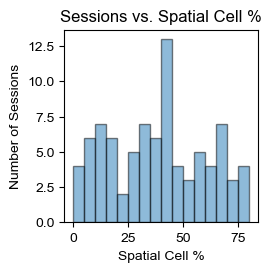

In [12]:
''' Examine grid & NGS cell densities quickly as a sanity check'''

# Assess distribution of grid/ngs cell densities
print('Mean, SEM Spatial Cell %')
print(np.mean(per99), stats.sem(per99))

#plot grid vs. ngs cell % distributions
fig, ax = plt.subplots(1,1,figsize = (2.5,2.5), sharey = True)
ax.hist(per99, bins = np.arange(0,85,5), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax.set_title('Sessions vs. Spatial Cell %')
ax.set_ylabel('Number of Sessions')
ax.set_xlabel('Spatial Cell %')

plt.show()

In [13]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
y_ind = []
age_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
y_sind = y_sind.astype(int)

print(mice[y_ind], mice[age_ind])
print(len(mice[y_ind]), len(mice[age_ind]))
print(len(y_sind), len(age_sind))
Nold = len(mice[age_ind])
Nyoung = len(mice[y_ind])

['Y11' 'Y16' 'Y17' 'Y18' 'Y19' 'Y2' 'Y3' 'Y4' 'Y9'] ['A12' 'A13' 'A3' 'A4' 'A5' 'A6' 'A7']
9 7
44 42


In [14]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,Nold)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,Nyoung)])
col_animal = [col_animal_young, col_animal_old]

col_session_young = []
col_session_old = []
for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in RF_aged_mice:
            idx = np.where(mice == m)[0][0]
            col_session_old.append(col_animal[1][0][idx])
        else:
            idx = np.where(mice == m)[0][0] - Nold
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young,col_session_old]

label_mice = ['Y11', 'Y16', 'Y17', 'Y18', 'Y19', 'Y2', 'Y3', 'Y4','Y9','A12', 'A13', 'A3', 'A4', 'A5', 'A6', 'A7']

# set up handles
from itertools import repeat
per99 = [mper99[y_ind], mper99[age_ind]]

handles = []
for i in range(len(per99)):
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)

# Verify classification of spatial cells (Figure 5a-d).

A12


  0%|          | 0/6 [00:00<?, ?it/s]

052022_record3
366


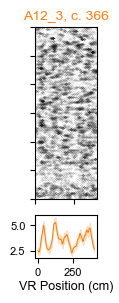

A13


  0%|          | 0/6 [00:00<?, ?it/s]

051022_record6
210


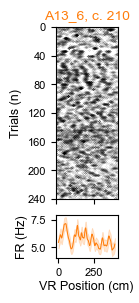

Y18


  0%|          | 0/6 [00:00<?, ?it/s]

062022_record1
398


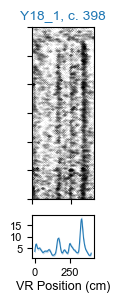

Y19


  0%|          | 0/6 [00:00<?, ?it/s]

062822_record1
740


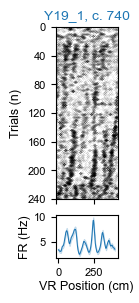

In [16]:
''' Sequentially Plot Example Spatial Cell Rasters with Tuning Curves (Figure 5a)'''

#set parameters
LW_FR = 0.75
LW_SEM = 0.5
widths = [1]
heights = [1.6,0.4]
dt = 0.02
count = 0
cellcount = 0

#specify cells to use
from matplotlib.lines import Line2D
from copy import copy

ex_mice = ['Y19','Y18','A13','A12'] # mouse names for Fig 5 examples
ex_sessions = ['062822_record1','062022_record1','051022_record6','052022_record3'] #list of sssions

ex_spatialcells = [366,210,398,740]
minimalistbool = [True,False,True,False]
sesh = [3,6,1,1]
cols = ['C1','C1','C0','C0']

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    else:
        print(m)
    
    for s in tdqm(session):
        
        if s not in ex_sessions:
            continue
        else:
            print(s)
            
            d = data[m][s]

            #load in data
            rawdata_file = 'RAW_' + m + '_' + s + '.npy'
            behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
            spikes_file = 'SPIKES_' + m + '_' + s +'.npy'

            raw = np.load(load_folder + rawdata_file, allow_pickle=True)
            cell_IDs = raw.item().get('cellsfil')
            behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
            Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins

            #get behavioral data
            posx = behaviorfil[:,0]
            trials = behaviorfil[:, 2]
            trials = -1 * trials

            # generate aligned position tuning curve
            dt = 0.02
            FR, binned_pos, FR_sem, occ = ps.tuning_curve(posx, Y, dt, b=2, l=2, SEM=True)

            ## PLOT RASTER w/ CONTEXT LABEL
            c = ex_spatialcells[cellcount]
            print(c)
            minimalist = minimalistbool[cellcount]
            col = cols[cellcount]

            fig = plt.figure()
            fig.set_size_inches(0.8,3)
            gs = gridspec.GridSpec(ncols = 1 , nrows = 2, hspace=0.15, figure = fig, width_ratios = widths, height_ratios = heights)

            ax = fig.add_subplot(gs[0, 0])
            sdx = Y[:, np.where(cell_IDs==c)[0][0]].astype(bool)
            ax.plot(posx[sdx], trials[sdx], '.', color = 'k', markersize = 0.2, alpha=0.4)
            ax.tick_params(labelsize = 8)
            ax.set_xlim((0, 400))
            ax.set_ylim((np.min(trials),0))
            ax.set_yticks([-240,-200,-160,-120,-80,-40,0])
            ax.set_yticklabels([240,200,160,120,80,40,0])
            ax.set_xticks([0,200,400])
            ax.set_title(str(m) + '_' + str(sesh[cellcount]) + ', c. ' + str(c), fontsize = 10, color = col)

            #plot example tuning curve
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            ax1 = fig.add_subplot(gs[1,0])
            ax1.plot(binned_pos, FR[:,sdx], linewidth = LW_FR, color = col)
            ax1.fill_between(binned_pos, FR[:, sdx] + FR_sem[:, sdx], FR[:, sdx] - FR_sem[:, sdx], 
                                 color=col, lw=LW_SEM, alpha=0.2)
            ax1.set_xlabel('VR Position (cm)', fontsize = 9, labelpad = 2)
            ax1.set_xticks([0,200,400])
            ax1.tick_params(labelsize = 8)

            if minimalist:
                ax.tick_params(labelleft=False, labelbottom=False)
            else:
                ax.tick_params(labelleft=True, labelbottom=False)
                #ax.set_xlabel('VR Position (cm)', fontsize = 9)
                ax.set_ylabel('Trials (n)', fontsize = 9)
                ax1.set_ylabel('FR (Hz)', fontsize = 9, labelpad = 2)

            fig.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_5A.png', dpi = 400)
            fig.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_5A.svg', dpi = 400)
            plt.show()

            cellcount += 1

In [17]:
''' For spatial & border cells, save shuffle distributions of sparsity & coherence  '''

spatialsparsity = []
spatialshuffsparsity = []
spatialcoherence = []
spatialshuffcoherence = []

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')

        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        
        sparsity_scores = d['sparsityscores']
        spatialcoherence_scores = d['spatialcoherencescores']
        shuffsparsityscores = d['shuffsparsityscores']
        shuffspatialcoherencescores = d['shuffspatialcoherencescores']
        
        for i, c in enumerate(spatialcells):
            sdx = np.where(cell_IDs == c)[0][0]
        
            shuffsparsity = np.random.choice(np.ravel(shuffsparsityscores[:,sdx]))
            shuffcoherence = np.random.choice(np.ravel(shuffspatialcoherencescores[:,sdx]))
            coherence = spatialcoherence_scores[sdx]
            sparsity = sparsity_scores[sdx]
            
            spatialsparsity = np.append(spatialsparsity,sparsity)
            spatialshuffsparsity = np.append(spatialshuffsparsity,shuffsparsity)
            spatialcoherence = np.append(spatialcoherence,coherence)
            spatialshuffcoherence = np.append(spatialshuffcoherence,shuffcoherence)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

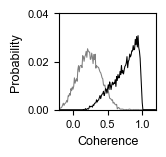


Mean, SEM Real Coherence:
0.7390792074922479 0.0019328191913428486
Mean, SEM Shuffle Coherence:
0.22936345882615597 0.0018121011484174083
stat = 50.0
p_cells = 0.0
n model pairs coherence: 8476


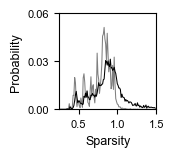


Mean, SEM Real Sparsity:
0.9153549378551794 0.003672820847098984
Mean, SEM Shuffle Sparsity:
0.771497716751893 0.0016040650655885045
stat = 761.0
p_cells = 0.0
n model pairs sparsity: 8476


In [65]:
''' Plot distribution of randomly selected shuffles vs. real sparsity/coherence; Figure 5B, C '''

bins = np.arange(-0.2,1.2,0.01)
bcoherence, bin_edges = np.histogram(spatialcoherence, bins = bins)
pdf = bcoherence / sum(bcoherence)

shuffcoherence, shuffbin_edges = np.histogram(spatialshuffcoherence, bins = bins)
shuffpdf = shuffcoherence / sum(shuffcoherence)

#Plot Figure 5B
fig, ax = plt.subplots(figsize = (1.25,1.25))
#ax.hist(spatialcoherence, 20, density = True, histtype = 'step', color = 'k')
#ax.hist(spatialshuffsparsity, 20, density = True, histtype = 'step', color = 'k', alpha = 0.5)
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Coherence', fontsize = 9)
ax.set_xlim([-0.2,1.2])
ax.set_ylim([0,0.04])
ax.set_yticks([0,0.02,0.04])
ax.set_xticks([0,0.5,1.0])
ax.tick_params(labelsize = 8)
plt.savefig(save_folder + '5B.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '5B.svg', dpi=400, bbox_inches='tight')
plt.show()

#STATS
#COHERENCE SPATIAL VS SHUFF
print('\nMean, SEM Real Coherence:')
print(np.nanmean(spatialcoherence), stats.sem(spatialcoherence, nan_policy = 'omit')) 
print('Mean, SEM Shuffle Coherence:')
print(np.nanmean(spatialshuffcoherence), stats.sem(spatialshuffcoherence, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(spatialcoherence, spatialshuffcoherence)
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))
print('n model pairs coherence: ' + str(len(spatialcoherence[~np.isnan(spatialshuffcoherence)])))

bins = np.arange(0.25,1.5,0.01)

bsparsity, bin_edges = np.histogram(spatialsparsity, bins = bins)
pdf = bsparsity / sum(bsparsity)

shuffbsparsity, shuffbin_edges = np.histogram(spatialshuffsparsity, bins = bins)
shuffpdf = shuffbsparsity / sum(shuffbsparsity)

#Plot Figure 5C
fig, ax = plt.subplots(figsize = (1.25,1.25))
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Sparsity', fontsize = 9)
ax.set_xlim([0.25,1.5])
ax.set_ylim([0,0.06])
ax.tick_params(labelsize = 8)
ax.set_yticks([0,0.03,0.06])
plt.savefig(save_folder + '5C.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '5C.svg', dpi=400, bbox_inches='tight')
plt.show()

#STATS
#sparsity SPATIAL VS SHUFF
print('\nMean, SEM Real Sparsity:')
print(np.nanmean(spatialsparsity), stats.sem(spatialsparsity, nan_policy = 'omit')) 
print('Mean, SEM Shuffle Sparsity:')
print(np.nanmean(spatialshuffsparsity), stats.sem(spatialshuffsparsity, nan_policy = 'omit')) 

stat, p_diff = stats.wilcoxon(spatialsparsity[~np.isnan(spatialshuffsparsity)], spatialshuffsparsity[~np.isnan(spatialshuffsparsity)])
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))
print('n model pairs sparsity: ' + str(len(spatialsparsity[~np.isnan(spatialshuffsparsity)])))

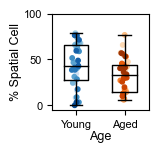

In [18]:
''' Plot Spatial Density by Session across Age Groups (Figure 5D) '''

#Plot Figure 5d
fig, ax = plt.subplots(figsize = (1.25,1.25))
per99 = [sper99[y_sind],sper99[age_sind]]
labels = ['Young','Aged']
w = 0.5

plt.boxplot(per99, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session Spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% Spatial Cell', fontsize=9, labelpad=1)
ax.set_ylim([-5,100])
ax.tick_params(labelsize = 8)

for i in range(len(per99)):
    y = per99[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + '5D.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '5D.svg', dpi=400, bbox_inches='tight')
plt.show()

In [19]:
''' Statistically Compare Young vs. Aged Spatial Cell Density '''

print('\nperSC_young ± SEM, perSC_old ± SEM')
print(str(np.round(np.mean(sper99[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sper99[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sper99[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sper99[age_sind]), 2)))

stat, p_diff = stats.ranksums(sper99[y_sind],sper99[age_sind])
print('\np_session, % P99 spatial cell = ' + str(p_diff))
print('n young, n aged = ' + str(len(y_sind)) + ', ' + str(len(age_sind)))


perSC_young ± SEM, perSC_old ± SEM
44.29 ± 3.52 ; 32.37 ± 2.79

p_session, % P99 spatial cell = 0.01364298972125631
n young, n aged = 44, 42


# Spatial Cell Coherence, Spatial Info, Stability (Figure 5E-G)

In [18]:
'''Store Spatial Coherence & Shuff Coherence Scores'''
dt = 0.02

scoherence99 = []
sshufcoherence = []

coherencea = []
coherencey = []

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spatialcell95_file = 'spatialcell99_' + m + '_' + s + '.npy'
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')

        spatialcell99 = d['spatialcell99']
        spatialcells99 = cell_IDs[spatialcell99]
        
        #get cell IDs, filtered behavioral/spike data, & relevant scores
        cell_IDs = raw.item().get('cellsfil')
        spatialcoherence_scores = d['spatialcoherencescores']
        shuffspatialcoherencescores = d['shuffspatialcoherencescores']
        
        #Calculate Spatial Cell Density
        coherencescore99 = []
        shuffcoherence99 = []
        for i, c in enumerate(spatialcells99):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
    
            coherencescore99 = np.append(coherencescore99,spatialcoherence_scores[sdx])
            shuffcoherence99 = np.append(shuffcoherence99, np.nanmean(np.ravel(shuffspatialcoherencescores[:,sdx])))
            
        #pool data into session arrays    
        scoherence99 = np.append(scoherence99, np.nanmean(coherencescore99))
        sshufcoherence = np.append(sshufcoherence, np.nanmean(shuffcoherence99))
        
        #report all data by age group
        if m in all_aged_mice:
            coherencea = np.append(coherencea, coherencescore99)
        else: 
            coherencey = np.append(coherencey, coherencescore99)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_9012\58844059.py:46: RuntimeWarning: Mean of empty slice
  scoherence99 = np.append(scoherence99, np.nanmean(coherencescore99))
C:\Users\Python\AppData\Local\Temp\ipykernel_9012\58844059.py:47: RuntimeWarning: Mean of empty slice
  sshufcoherence = np.append(sshufcoherence, np.nanmean(shuffcoherence99))


In [16]:
''' Find where I will have NaNs for Scores, Mean & Peak FR, Slope, Y-Int'''
nan_idx99 = np.where((sper99 == 0))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sind99 = np.setdiff1d(y_sind, nan_idx99)
age_sind99 = np.setdiff1d(age_sind, nan_idx99)

# Adjust colormaps
yidx = []
aidx = []
for i in nan_idx99:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_young99 = np.delete(col_session_young, list((yidx).astype(int)), axis = 0)
col_session_old99 = np.delete(col_session_old, list(aidx), axis = 0)
col_session99 = [col_session_young99, col_session_old99] 

# This will fix session stats & box plots are plotted.

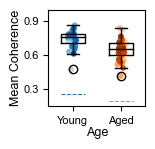

In [17]:
''' Plot Spatial Cell Coherence vs. Shuffle by Age Group (Figure 5E)'''
fig, ax = plt.subplots(figsize = (1.25,1.25))
scoherence99_tog = [scoherence99[y_sind99],scoherence99[age_sind99]]

labels = ['Young','Aged']
w = 0.5

plt.boxplot(scoherence99_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session Spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('Mean Coherence', fontsize=9, labelpad=1)
ax.set_ylim([0.15,1])
ax.set_yticks([0.3,0.6,0.9])
ax.tick_params(labelsize = 8)

for i in range(len(scoherence99_tog)):
    y = scoherence99_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session99[i], edgecolors = col_session99[i], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1)
ax.hlines(np.mean(sshufcoherence[y_sind99]), 0.75, 1.25, color = 'C0', linestyle ='dashed', linewidth = 0.75, label = 'Young Shuffle')
ax.hlines(np.mean(sshufcoherence[age_sind99]), 1.75, 2.25, color = 'C1', linestyle ='dashed', linewidth = 0.75, label = 'Aged Shuffle')
plt.savefig(save_folder + '5E.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '5E.svg', dpi=400, bbox_inches='tight')
plt.show()

In [23]:
''' Statistics on Coherence '''
print('Young v. Aged Real Results:')
print('coherenceSC_young ± SEM, coherenceSC_old ± SEM')
print(str(np.round(np.mean(scoherence99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(scoherence99[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(scoherence99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(scoherence99[age_sind99]), 4)))

stat, p_diff = stats.ranksums(scoherence99[y_sind99],scoherence99[age_sind99])
print('stat = ' + str(stat))
print('p_session, P99 spatial coherence = ' + str(p_diff))
print('n young, n aged = ' + str(len(y_sind99)) + ', ' + str(len(age_sind99)))

print('\nYoung v. Aged Shuffle Results:')
print('shuffcoherenceSC_young ± SEM, shuffcoherenceSC_old ± SEM')
print(str(np.round(np.mean(sshufcoherence[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshufcoherence[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sshufcoherence[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshufcoherence[age_sind99]), 4)))

stat, p_diff = stats.ranksums(sshufcoherence[y_sind99],sshufcoherence[age_sind99])
print('stat = ' + str(stat))
print('p_session, P99 spatial shuff coherence = ' + str(p_diff))

print('\nYoung Shuffle vs. Real Results:')
print('shuffcoherenceSC_young ± SEM, coherenceSC_young ± SEM')
print(str(np.round(np.mean(sshufcoherence[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshufcoherence[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(scoherence99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(scoherence99[y_sind99]), 4)))

stat, p_diff = stats.wilcoxon(sshufcoherence[y_sind99],scoherence99[y_sind99])
print('stat = ' + str(stat))
print('p_session, P99 spatial coherence = ' + str(p_diff))

print('\nAged Shuffle vs. Real Results:')
print('shuffcoherenceSC_old ± SEM, coherenceSC_old ± SEM')
print(str(np.round(np.mean(sshufcoherence[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshufcoherence[age_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(scoherence99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(scoherence99[age_sind99]), 4)))

stat, p_diff = stats.wilcoxon(sshufcoherence[age_sind99],scoherence99[age_sind99])
print('stat = ' + str(stat))
print('p_session, P99 spatial coherence = ' + str(p_diff))

Young v. Aged Real Results:
coherenceSC_young ± SEM, coherenceSC_old ± SEM
0.7425 ± 0.0108 ; 0.648 ± 0.0136
stat = 5.045386221099917
p_session, P99 spatial coherence = 4.5260616809627313e-07
n young, n aged = 43, 42

Young v. Aged Shuffle Results:
shuffcoherenceSC_young ± SEM, shuffcoherenceSC_old ± SEM
0.2517 ± 0.0081 ; 0.193 ± 0.0084
stat = 4.491624318784073
p_session, P99 spatial shuff coherence = 7.068202278383403e-06

Young Shuffle vs. Real Results:
shuffcoherenceSC_young ± SEM, coherenceSC_young ± SEM
0.2517 ± 0.0081 ; 0.7425 ± 0.0108
stat = 0.0
p_session, P99 spatial coherence = 2.2737367544323206e-13

Aged Shuffle vs. Real Results:
shuffcoherenceSC_old ± SEM, coherenceSC_old ± SEM
0.193 ± 0.0084 ; 0.648 ± 0.0136
stat = 0.0
p_session, P99 spatial coherence = 4.547473508864641e-13


In [36]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each P99 Spatial Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf


sex = list(animalmeta.Sex[mice_ind])
csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex = sex[np.where(mice == m)[0][0]]
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        spatialcell99 = d['spatialcell99'].astype(bool)
        spatialcells99 = cell_IDs[spatialcell99]
        
        for j, c in enumerate(spatialcells99):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     Coherence
No. Observations:       8476        Method:                 REML     
No. Groups:             16          Scale:                  0.0107   
Min. group size:        7           Log-Likelihood:         2940.2415
Max. group size:        1100        Converged:              Yes      
Mean group size:        529.8                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.753    0.021 35.316 0.000  0.712  0.795
C(AgeGroup)[T.3.0]         -0.057    0.024 -2.334 0.020 -0.105 -0.009
C(Sex)[T.M]                 0.032    0.023  1.376 0.169 -0.013  0.077
Session                    -0.005    0.002 -3.149 0.002 -0.008 -0.002
Session:C(AgeGroup)[T.3.0] -0.004   

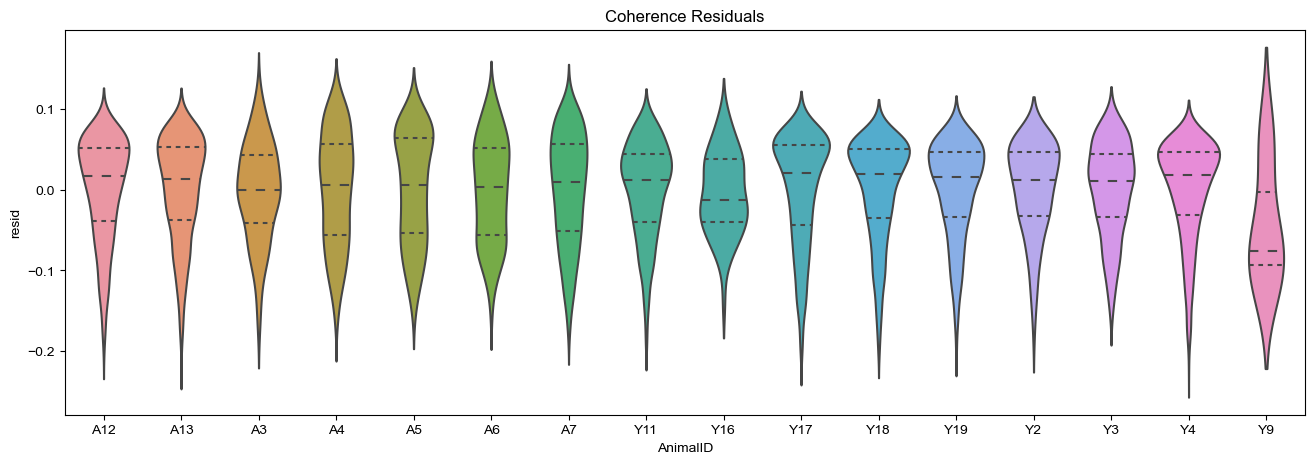

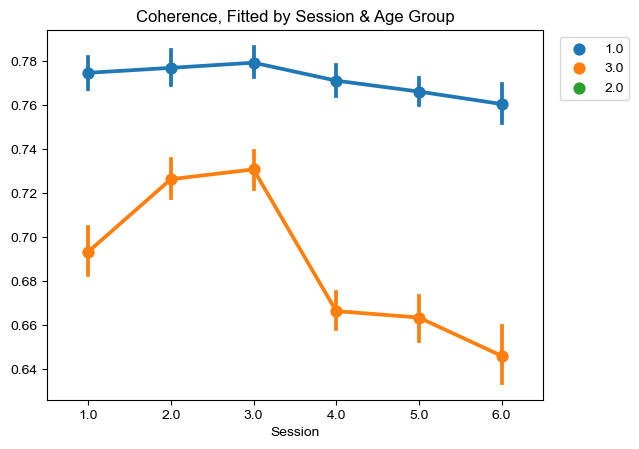

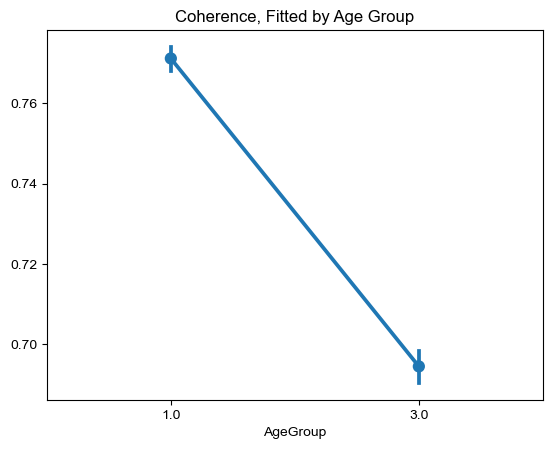

Raw Data Mean across All Sessions by Animal:
AnimalID
A12    0.753030
A13    0.741916
A3     0.595917
A4     0.647412
A5     0.689160
A6     0.613165
A7     0.674652
Y11    0.751703
Y16    0.717688
Y17    0.767714
Y18    0.783182
Y19    0.771792
Y2     0.772468
Y3     0.743699
Y4     0.789603
Y9     0.610690

Fitted Data Mean across All Sessions by Animal:
AnimalID
A12    0.752533
A13    0.741628
A3     0.598272
A4     0.647575
A5     0.688719
A6     0.614267
A7     0.674573
Y11    0.751875
Y16    0.722717
Y17    0.767690
Y18    0.783099
Y19    0.771744
Y2     0.771507
Y3     0.743562
Y4     0.789187
Y9     0.655334


In [43]:
''' Run LMM on Coherence & Report Fitted Data for Figure 7 

NOTE: Sex & cohort are 100% collinear for the RF Task. Therefore, only sex is as a fixed effect used in this model. 

'''

import statsmodels.api as sm

#gather dependent variables into lists
Coherence = list(np.concatenate((coherencea,coherencey)))

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, Coherence))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID', 'Sex', 'AgeGroup','Cohort','Coherence'])

#handle NaNs
df = df.dropna()

# Coherence  Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mcoherence = smf.mixedlm('Coherence ~ 1 + C(AgeGroup) + C(Sex) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml = True)
print(mcoherence.summary())
print(mcoherence.wald_test_terms(scalar = False))
#print(mcoherence.aic)
#print(mcoherence.bic)

#plots of residuals
df['resid'] = mcoherence.resid
fig, ax = plt.subplots(figsize = (16,5))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Coherence Residuals')
plt.show()

#plot fitted values
hue_order = [1.0, 3.0, 2.0]
sns.pointplot(x = df['Session'], y = mcoherence.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Coherence, Fitted by Session & Age Group')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

sns.pointplot(x = df['AgeGroup'], y = mcoherence.fittedvalues)
plt.title('Coherence, Fitted by Age Group')
plt.show()

df['fitted'] = mcoherence.fittedvalues
animalgrouped = df.groupby(['AnimalID'])

print('Raw Data Mean across All Sessions by Animal:')
print(animalgrouped['Coherence'].mean().to_string(index=True))

print('\nFitted Data Mean across All Sessions by Animal:')
print(animalgrouped['fitted'].mean().to_string(index=True))

# No sig. session x age effects... Therefore, not reporting change in mean across sessions
#print('\nFitted Data Mean across All Sessions by Animal:')
#print('First Three: ')
#print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))
#print('Last Three: ')
#print(df.loc[df['Session'] >= 4].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))

In [21]:
''' Calculate Spatial Information Scores for all Spatial Cells '''

# parameters
track_length = 400 #cm
b = 2 #cm
n_bin = int(track_length/b)
dt = 0.02

sinfo99 = []
infoy = []
infoa = []

for m, session in zip(mice,sessions):
    
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

        cell_IDs = raw.item().get('cellsfil')
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        post = behaviorfil[:,3]
        spatialcells99 = d['spatialcells99']
        total_time = max(post) - min(post)
        
        #provide some track info & calculate smooth spatially binned FR
        smoothFR, _ , smoothocc = ps.tuning_curve(posxfil, Y, dt, b=2, smooth=True, l=2, SEM=False, occupancy = True) #FR shape (n_bins, n_cells)
            
        info99 = []
        for i, c in enumerate(spatialcells99):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            meanFR = np.mean(smoothFR[:,sdx]) #calculate spatial info score
            products = []
            for b in range(0,n_bin):
                binmeanFR = smoothFR[b,sdx]
                div = binmeanFR / meanFR
                if div == 0:
                    products = np.append(products,0)
                else: 
                    log = math.log2(div)
                    prob = smoothocc[b,sdx]/total_time
                    prod = prob*log*div 
                    products = np.append(products,prod)
            info99 = np.append(info99, np.sum(products))  
            
        #pool data into session arrays    
        sinfo99 = np.append(sinfo99, np.nanmean(info99))
        
        #pool data by age group
        if m in all_aged_mice:
            infoa = np.append(infoa, info99)
        else: 
            infoy = np.append(infoy, info99)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_9012\652991208.py:56: RuntimeWarning: Mean of empty slice
  sinfo99 = np.append(sinfo99, np.nanmean(info99))


In [25]:
''' Get 1x Spatial Info Shuffle Score for each Cell '''

sshufinfo99 = []

# parameters
track_length = 400 #cm
b = 2 #cm
n_bin = int(track_length/b)
dt = 0.02

for m, session in zip(mice,sessions):
        
    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        ##Generate shuffled spike train for spatial cells only
        #get stuff you will to shuffle & re-filter spike times
        sp = raw.item().get('sp')
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        rawposx = raw.item().get('posx')
        rawpost = raw.item().get('post')
        rawspeed = raw.item().get('speed')
        
        dt = np.unique(np.round(np.diff(rawpost),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(rawpost) == 0)[0]
        else:
            dt_to_trash = [] 

        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        speed_to_trash = get.find(rawspeed < 2)
        pos_to_trash = get.find((rawposx < 0) | (rawposx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(len(rawspeed)), trash_idx)
        
        B = np.zeros((len(rawspeed), len(spatialcells))) # reset empty shuffled FR matrix    
        for i, c in enumerate(spatialcells):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)

            #get actual spike times for each cell
            st = spiket[cluster_id == c]
            st = st[(st >= min(rawpost)) & (st <= max(rawpost))]

            #get shuffle times
            st_shuf = st - min(rawpost)
            total_time = max(rawpost) - min(rawpost)
            add = np.random.uniform(0.02,total_time,1)
            st_shuf = (st_shuf + add) % total_time
            st_shuf = st_shuf + min(rawpost)

            #get unfiltered spike train
            spike_ct = np.zeros_like(rawpost)
            spike_idx = np.digitize(st_shuf, rawpost) #obs corresponding to where each shuffled spike occurs

            idx, cts = np.unique(spike_idx, return_counts = True)
            spike_ct[idx] = cts
            B[:,i] = spike_ct

            #check for & interpolate any missing values
            if sum(np.isnan(B[:,i])) > 0:
                B[:,i] = get.nan_interp(B[:,i])  

        #apply filter spike train by speed, dt, & posx errors
        B = B[keep_idx,:]
            
        #get some data & cell IDs
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        post = behaviorfil[:,3]
        total_time = max(post) - min(post)
        
        #provide some track info & calculate smooth spatially binned FR
        smoothFR, _ , smoothocc = ps.tuning_curve(posxfil, B, dt, b=2, smooth=True, l=2, SEM=False, occupancy = True) #FR shape (n_bins, n_cells)
           
        #get spatial info for shuffle activity
        shuffinfo99 = [] 
        for i, c in enumerate(spatialcells):
            meanFR = np.mean(smoothFR[:,i]) #calculate spatial info score
            products = []
            for b in range(0,n_bin):
                binmeanFR = smoothFR[b,i]
                div = binmeanFR / meanFR
                if div == 0:
                    products = np.append(products,0)
                else: 
                    log = math.log2(div)
                    prob = smoothocc[b,i]/total_time
                    prod = prob*log*div 
                    products = np.append(products,prod)
            shuffinfo99 = np.append(shuffinfo99, np.sum(products)) 
            
        sshufinfo99 = np.append(sshufinfo99, shuffinfo99)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

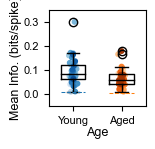

In [26]:
''' Plot Spatial Cell Spatial Information vs. Shuffle by Age Group (Figure 5F) '''
fig, ax = plt.subplots(figsize = (1.25,1.25))
sinfo99_tog = [sinfo99[y_sind99],sinfo99[age_sind99]]

labels = ['Young','Aged']
w = 0.5

plt.boxplot(sinfo99_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session Spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('Mean Info. (bits/spike)', fontsize=9, labelpad=1)
ax.set_ylim([-0.05,0.35])
ax.set_yticks([0,0.1,0.2,0.3])
ax.tick_params(labelsize = 8)

for i in range(len(sinfo99_tog)):
    y = sinfo99_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session99[i], edgecolors = col_session99[i], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
ax.hlines(np.mean(sshufinfo99[y_sind99]), 0.75, 1.25, color = 'C0', linestyle ='dashed', linewidth = 0.75, label = 'Young Shuffle')
ax.hlines(np.mean(sshufinfo99[age_sind99]), 1.75, 2.25, color = 'C1', linestyle ='dashed', linewidth = 0.75, label = 'Aged Shuffle')
plt.savefig(save_folder + '5F.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '5F.svg', dpi=400, bbox_inches='tight')
plt.show()

In [27]:
''' Statistics on Spatial Information '''
print('Young v. Aged Real Results:')
print('infoSC_young ± SEM, infoSC_old ± SEM')
print(str(np.round(np.mean(sinfo99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sinfo99[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sinfo99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sinfo99[age_sind99]), 4)))

stat, p_diff = stats.ranksums(sinfo99[y_sind99],sinfo99[age_sind99])
print('stat = ' + str(stat))
print('p_session, P99 spatial info = ' + str(p_diff))
print('n young, n aged = ' + str(len(y_sind99)) + ', ' + str(len(age_sind99)))

print('\nYoung v. Aged Shuffle Results:')
print('shuffinfoSC_young ± SEM, shuffinfoSC_old ± SEM')
print(str(np.round(np.mean(sshufinfo99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshufinfo99[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sshufinfo99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshufinfo99[age_sind99]), 4)))

stat, p_diff = stats.ranksums(sshufinfo99[y_sind99],sshufinfo99[age_sind99])
print('stat = ' + str(stat))
print('p_session, P99 spatial shuff info = ' + str(p_diff))

print('\nYoung Shuffle vs. Real Results:')
print('shuffinfoSC_young ± SEM, infoSC_young ± SEM')
print(str(np.round(np.mean(sshufinfo99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshufinfo99[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sinfo99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sinfo99[y_sind99]), 4)))

stat, p_diff = stats.wilcoxon(sshufinfo99[y_sind99],sinfo99[y_sind99])
print('stat = ' + str(stat))
print('p_session, P99 spatial info = ' + str(p_diff))

print('\nAged Shuffle vs. Real Results:')
print('shuffinfoSC_old ± SEM, infoSC_old ± SEM')
print(str(np.round(np.mean(sshufinfo99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshufinfo99[age_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sinfo99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sinfo99[age_sind99]), 4)))

stat, p_diff = stats.wilcoxon(sshufinfo99[age_sind99],sinfo99[age_sind99])
print('stat = ' + str(stat))
print('p_session, P99 spatial info = ' + str(p_diff))

Young v. Aged Real Results:
infoSC_young ± SEM, infoSC_old ± SEM
0.0928 ± 0.0081 ; 0.0636 ± 0.0056
stat = 2.94460694088584
p_session, P99 spatial info = 0.0032336517487080827
n young, n aged = 43, 42

Young v. Aged Shuffle Results:
shuffinfoSC_young ± SEM, shuffinfoSC_old ± SEM
0.0084 ± 0.0015 ; 0.0036 ± 0.0012
stat = 3.3841005141523834
p_session, P99 spatial shuff info = 0.0007141185499335199

Young Shuffle vs. Real Results:
shuffinfoSC_young ± SEM, infoSC_young ± SEM
0.0084 ± 0.0015 ; 0.0928 ± 0.0081
stat = 4.0
p_session, P99 spatial info = 1.5916157281026244e-12

Aged Shuffle vs. Real Results:
shuffinfoSC_old ± SEM, infoSC_old ± SEM
0.0036 ± 0.0012 ; 0.0636 ± 0.0056
stat = 0.0
p_session, P99 spatial info = 4.547473508864641e-13


C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     Info     
No. Observations:       8476        Method:                 REML     
No. Groups:             16          Scale:                  0.0072   
Min. group size:        7           Log-Likelihood:         4329.2248
Max. group size:        1100        Converged:              Yes      
Mean group size:        529.8                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.098    0.012  8.253 0.000  0.075  0.121
C(AgeGroup)[T.3.0]         -0.038    0.014 -2.684 0.007 -0.065 -0.010
C(Sex)[T.M]                 0.018    0.012  1.435 0.151 -0.006  0.041
Session                    -0.002    0.001 -1.841 0.066 -0.005  0.000
Session:C(AgeGroup)[T.3.0]  0.006   

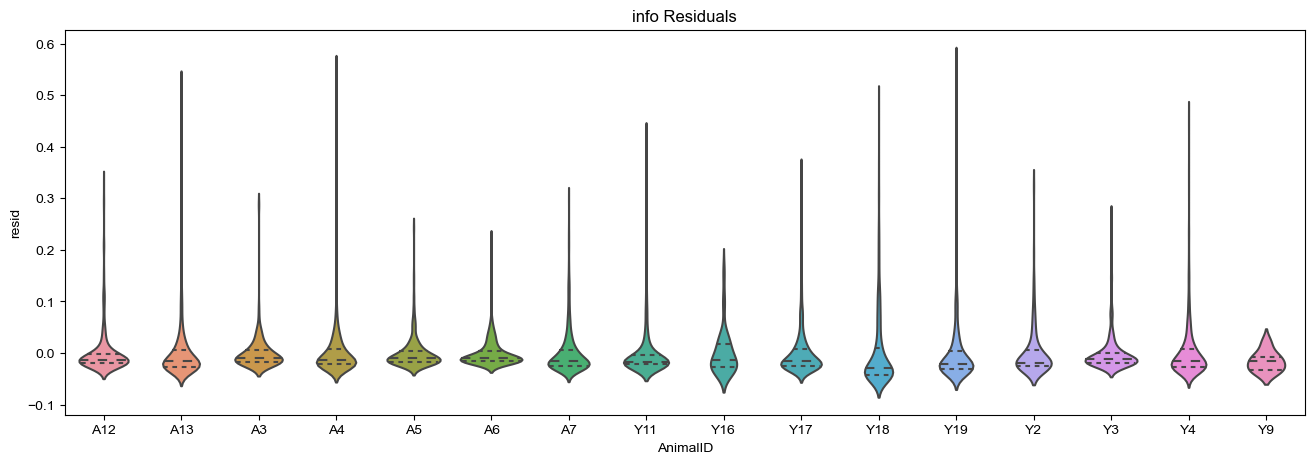

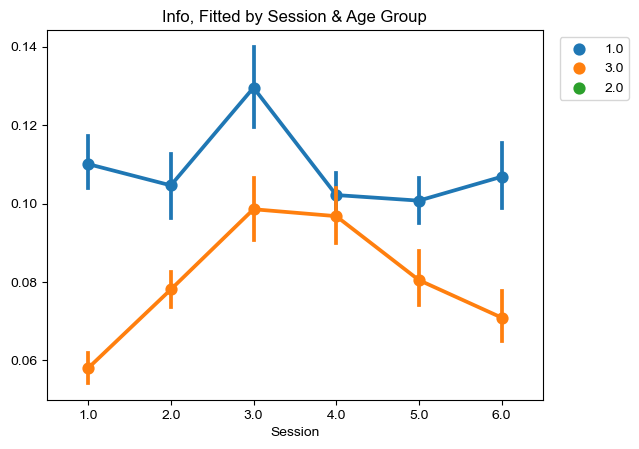

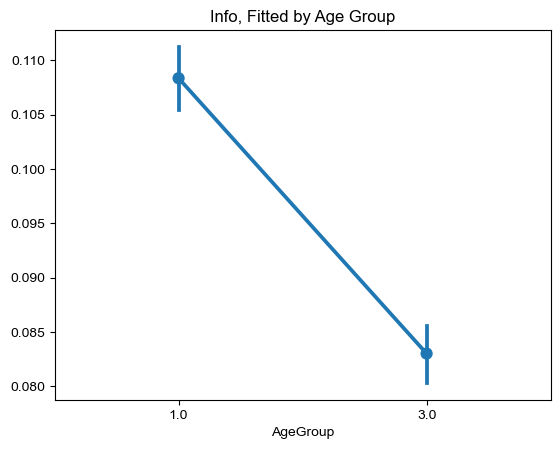

Raw Data Mean across All Sessions by Animal:
AnimalID
A12    0.072564
A13    0.102368
A3     0.063123
A4     0.084348
A5     0.063105
A6     0.056551
A7     0.090035
Y11    0.074640
Y16    0.115783
Y17    0.097230
Y18    0.146726
Y19    0.112102
Y2     0.088231
Y3     0.065180
Y4     0.114110
Y9     0.060716

Fitted Data Mean across All Sessions by Animal:
AnimalID
A12    0.072916
A13    0.102115
A3     0.063922
A4     0.084036
A5     0.063474
A6     0.057358
A7     0.089639
Y11    0.075422
Y16    0.115322
Y17    0.097375
Y18    0.146166
Y19    0.111987
Y2     0.088549
Y3     0.066156
Y4     0.113634
Y9     0.076468


In [41]:
''' Run LMM on Spatial Info & Report Fitted Data for Figure 7 '''

#gather dependent variables into lists
Info = list(np.concatenate((infoa,infoy)))

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, Info))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID', 'Sex', 'AgeGroup','Cohort','Info'])

#handle NaNs
df = df.dropna()

# Info  Dependent
vc = {'cells':'0 + C(Cell_ID)'}
minfo = smf.mixedlm('Info ~ 1 + C(AgeGroup) + C(Sex) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml = True)
print(minfo.summary())
print(minfo.wald_test_terms(scalar = False))
#print(minfo.aic)
#print(minfo.bic)

#plots of residuals
df['resid'] = minfo.resid
fig, ax = plt.subplots(figsize = (16,5))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('info Residuals')
plt.show()

#plot fitted values
hue_order = [1.0, 3.0, 2.0]
sns.pointplot(x = df['Session'], y = minfo.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Info, Fitted by Session & Age Group')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

sns.pointplot(x = df['AgeGroup'], y = minfo.fittedvalues)
plt.title('Info, Fitted by Age Group')
plt.show()

df['fitted'] = minfo.fittedvalues
animalgrouped = df.groupby(['AnimalID'])

print('Raw Data Mean across All Sessions by Animal:')
print(animalgrouped['Info'].mean().to_string(index=True))

print('\nFitted Data Mean across All Sessions by Animal:')
print(animalgrouped['fitted'].mean().to_string(index=True))

# No sig. session x age effects... Therefore, not reporting change in mean across sessions
#print('\nFitted Data Mean across All Sessions by Animal:')
#print('First Three: ')
#print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))
#print('Last Three: ')
#print(df.loc[df['Session'] >= 4].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))

In [28]:
''' Generate & Save Cross-Trial Correlation Matrices for each Spatial Cell '''

for m, session in zip(mice,sessions):
    
    if m in cohortb_mice:
        max_trials = 240
    else:
        max_trials = 200
        
    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = max_trials)
            
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 1, 1)
        else:
            alltrial = np.arange(0,max_trials,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        
        #count number of skipped dark trials
        ndarkskipped = 0
        for z in skippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, skippedtrials)
            
        #define random foraging trials only, excluding dark & gain change periods
        if m == 'Y9':
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
        elif m in cohortb_mice:
            start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
            end_idx = (np.where(skippedrawtrialfil >= 220)[0][0]).astype(int)
        else:
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
        
        #set ticks & text dynamically
        ticks = np.array([0, len(np.unique(skippedrawtrialfil[start_idx:end_idx]))//2 , len(np.unique(skippedrawtrialfil[start_idx:end_idx]))])
        
        #get smoothed by trial FR matrix excluding dark period sorted by context
        normFR, _, _ = ps.tuning_curve_bytrial(posx[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Y[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True) 
        
        #collect & plot cross-trial correlation matrices & save for the grid cell population
        allsim = np.zeros(shape = (len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(spatialcells)))
    
        for i, c in enumerate(spatialcells):
            sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
            sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 
            allsim[:,:,i] = sim
            
        # save matrix of cross-trial correlations
        d['allsim'] = allsim
                               
        allsim_file = 'allsim_' + m + '_' + s + '_'+ '.npy'
        np.save(save_folder + allsim_file, allsim)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\Desktop\GitHub\Herber2024\pipeline\process_spikes.py:358: RuntimeWarning: invalid value encountered in divide
  firing_rate[:, :, c] = (firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))/np.max(firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
''' Calculate Shuffled CTCM for each Spatial Cell '''

for m, session in zip(mice,sessions):
        
    if m in cohortb_mice:
        max_trials = 240
    else:
        max_trials = 200
        
    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        ##Generate shuffled spike train for spatial cells only
        #get stuff you will to shuffle & re-filter spike times
        sp = raw.item().get('sp')
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        rawposx = raw.item().get('posx')
        rawpost = raw.item().get('post')
        rawspeed = raw.item().get('speed')
        
        dt = np.unique(np.round(np.diff(rawpost),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(rawpost) == 0)[0]
        else:
            dt_to_trash = [] 

        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        speed_to_trash = get.find(rawspeed < 2)
        pos_to_trash = get.find((rawposx < 0) | (rawposx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(len(rawspeed)), trash_idx)
        
        B = np.zeros((len(rawspeed), len(spatialcells))) # reset empty shuffled FR matrix    
        for i, c in enumerate(spatialcells):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)

            #get actual spike times for each cell
            st = spiket[cluster_id == c]
            st = st[(st >= min(rawpost)) & (st <= max(rawpost))]

            #get shuffle times
            st_shuf = st - min(rawpost)
            total_time = max(rawpost) - min(rawpost)
            add = np.random.uniform(0.02,total_time,1)
            st_shuf = (st_shuf + add) % total_time
            st_shuf = st_shuf + min(rawpost)

            #get unfiltered spike train
            spike_ct = np.zeros_like(rawpost)
            spike_idx = np.digitize(st_shuf, rawpost) #obs corresponding to where each shuffled spike occurs

            idx, cts = np.unique(spike_idx, return_counts = True)
            spike_ct[idx] = cts
            B[:,i] = spike_ct

            #check for & interpolate any missing values
            if sum(np.isnan(B[:,i])) > 0:
                B[:,i] = get.nan_interp(B[:,i])  

        #apply filter spike train by speed, dt, & posx errors
        B = B[keep_idx,:]
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = max_trials)
            
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 1, 1)
        else:
            alltrial = np.arange(0,max_trials,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        
        #count number of skipped dark trials
        ndarkskipped = 0
        for z in skippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, skippedtrials)
            
        #define random foraging trials only, excluding dark & gain change periods
        if m == 'Y9':
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
        elif m in cohortb_mice:
            start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
            end_idx = (np.where(skippedrawtrialfil >= 220)[0][0]).astype(int)
        else:
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
        
        #set ticks & text dynamically
        ticks = np.array([0, len(np.unique(skippedrawtrialfil[start_idx:end_idx]))//2 , len(np.unique(skippedrawtrialfil[start_idx:end_idx]))])
        
        #get smoothed by trial FR matrix excluding dark period sorted by context
        normFR, _, _ = ps.tuning_curve_bytrial(posx[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], B[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True) 
            
        #collect & plot cross-trial correlation matrices & save for the grid cell population
        allshuffsim = np.zeros(shape = (len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(spatialcells)))
        for i, c in enumerate(spatialcells):
            sim , _  = ps.cross_trial_correlation(normFR[:,:,i], shift = False) 
            allshuffsim[:,:,i] = sim
        
        #save shuffled matrix of cross-trial correlations
        d['allshuffsim'] = allshuffsim
                               
        allshuffsim_file = 'allshuffsim_' + m + '_' + s + '_'+ '.npy'
        np.save(save_folder + allshuffsim_file, allshuffsim)       

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [24]:
''' Load in K-Means Requirements '''

from tqdm import tqdm
from lvl.factor_models import KMeans as lvl_kmeans
from lvl.factor_models import NMF as lvl_soft_kmeans
from lvl.resamplers import RotationResampler
from lvl.crossval import speckled_cv_scores 
from scipy.spatial.distance import cdist 
from scipy.special import logsumexp
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

In [25]:
''' Regenerate K-Means results for any sessions with onemap = False using optimal k selected in Figure 3 / S4 Notebook '''

yk = []
ak = []
optimalks = []

for m, session in zip(mice, sessions):    
    for s in tdqm(session):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        
        if len(spatialcells) > 10:

            onemapfile = 'onemap' + m + '_' + s + '.npy'
            onemap = np.load(fig3s4_folder + onemapfile)
            
            if onemap[0].astype(bool) == True:
                
                d['kmeans'] = {}
                d['kmeans']['onemap'] = onemap 
                
                optimalks = np.append(optimalks, 1)
                
                if m in RF_aged_mice:
                    ak = np.append(ak, 1)
                else:
                    yk = np.append(yk, 1)
            
            else:
        
                d['kmeans'] = {}
                d['kmeans']['onemap'] = onemap 

                #load optimal k
                SilN_file = 'SilN_' + m + '_' + s + '.npy'
                d['kmeans']['SilN'] = np.load(fig3s4_folder + SilN_file)
                SilN = d['kmeans']['SilN']
                
                optimalks = np.append(optimalks, SilN)
            
                if m in RF_aged_mice:
                    ak = np.append(ak, SilN)
                else:
                    yk = np.append(yk, SilN)
                
                #load FR tensor
                FRtensor_file = 'RF_FRtensor_' + m + '_' + s + '.npy'
                d['FRtensor'] = np.load(fig3s4_folder + FRtensor_file)
                Y = d['FRtensor'].copy()
                Y = Y.transpose(0, 2, 1)
                Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
                sim_vec = np.abs(pdist(Y_unwrapped, 'correlation')-1)
                sim = squareform(sim_vec)
                d['similarity'] = sim
                
                #run k-means
                model_kmeans = lvl_kmeans(n_components = SilN, n_restarts = 100)
                model_kmeans.fit(Y_unwrapped)
                W, H = model_kmeans.factors
                Y_hat = model_kmeans.predict()
                score = model_kmeans.score(Y_unwrapped)
                d['kmeans']['W'] = W
                d['kmeans']['H'] = H
                d['kmeans']['Y_hat'] = Y_hat 
                d['kmeans']['Y_hat'] = Y_hat 
                d['kmeans']['score'] = score

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
''' Relabel spatial cell network maps non-arbitrarily (map 0 - 3 == slowest to fastest) '''

for m, session in zip(mice, sessions):
    
    if m in cohortb_mice:
        max_trials = 240
    else:
        max_trials = 200
    
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]     
    
        #get corrected speed during non-dark & non-gain running
        posx = behaviorfil[:,0]
        speed = behaviorfil[:,1]
        trial = behaviorfil[:,2]
        max_trials = np.max(trial)
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = max_trials)
            
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 1, 1)
        else:
            alltrial = np.arange(0,max_trials,1)
        
        #count number of skipped dark trials
        ndarkskipped = 0
        for z in skippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, skippedtrials)
            
        #define random foraging trials only, excluding dark & gain change periods
        if m == 'Y9':
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
        elif m in cohortb_mice:
            start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
            end_idx = (np.where(skippedrawtrialfil >= 200)[0][0]).astype(int)
        else:
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
            
        if len(spatialcells) > 10: 
            
            RFspeed = speed[start_idx:end_idx]
            trials = skippedrawtrialfil[start_idx:end_idx]
            
            onemapfile = 'onemap' + m + '_' + s + '.npy'
            onemap = np.load(fig3s4_folder + onemapfile)
            
            if onemap[0].astype(bool) == False:
                
                #assign map 0 to be slowest if k = 2
                if (d['kmeans']['SilN'] == 2):
                    W = d['kmeans']['W']

                    # get map indices
                    map_idx = W[:, 0].astype(bool)
                    map0_idx = np.zeros_like(trials)
                    map1_idx = np.zeros_like(trials)
                    for i, t in enumerate(np.unique(trials)):
                        if map_idx[i]:
                            map0_idx[trials == t] = 1
                        else:
                            map1_idx[trials == t] = 1
                    map0_idx = map0_idx.astype(bool)
                    map1_idx = map1_idx.astype(bool)

                    speed_0 = np.nanmean(RFspeed[map0_idx])
                    speed_1 = np.nanmean(RFspeed[map1_idx])

                    if speed_1 < speed_0: # swap labels
                        d['map0_idx'] = 1
                    else:
                        d['map0_idx'] = 0

                #ditto, assign map 2 fastest if k = 3
                elif (d['kmeans']['SilN'] == 3):
                    W = d['kmeans']['W']

                    #get map indices
                    map0_idx = np.zeros_like(trials)
                    map1_idx = np.zeros_like(trials)
                    map2_idx = np.zeros_like(trials)
                    for i, t in enumerate(np.unique(trials)):
                        map_idx = np.where(W[i,:] == 1)[0][0]
                        if map_idx == 0:
                            map0_idx[trials == t] = 1
                        elif map_idx == 1:
                            map1_idx[trials == t] = 1
                        else:
                            map2_idx[trials == t] = 1
                    map0_idx = map0_idx.astype(bool)
                    map1_idx = map1_idx.astype(bool)
                    map2_idx = map2_idx.astype(bool)

                    # get assign map 0 to be the one with the greate number of trials in Context A
                    speed_0 = np.nanmean(RFspeed[map0_idx])
                    speed_1 = np.nanmean(RFspeed[map1_idx])
                    speed_2 = np.nanmean(RFspeed[map2_idx])

                    d['map0_idx'] = np.argmin([speed_0, speed_1, speed_2])
                    d['map2_idx'] = np.argmax([speed_0, speed_1, speed_2])
                    d['map1_idx'] = np.setdiff1d([0,1,2], [d['map0_idx'], d['map2_idx']])[0]

                #ditto but map 3 is fastest if k = 4       
                elif (d['kmeans']['SilN'] == 4):
                    W = d['kmeans']['W']

                    #get map indices
                    map0_idx = np.zeros_like(trials)
                    map1_idx = np.zeros_like(trials)
                    map2_idx = np.zeros_like(trials)
                    map3_idx = np.zeros_like(trials)
                    for i, t in enumerate(np.unique(trials)):
                        map_idx = np.where(W[i,:] == 1)[0][0]
                        if map_idx == 0:
                            map0_idx[trials == t] = 1
                        elif map_idx == 1:
                            map1_idx[trials == t] = 1
                        elif map_idx == 2:
                            map2_idx[trials == t] = 1
                        else:
                            map3_idx[trials == t] = 1
                    map0_idx = map0_idx.astype(bool)
                    map1_idx = map1_idx.astype(bool)
                    map2_idx = map2_idx.astype(bool)
                    map3_idx = map3_idx.astype(bool)

                    # get assign map 0 to be the one with the greate number of trials in Context A
                    speed_0 = np.nanmean(RFspeed[map0_idx])
                    speed_1 = np.nanmean(RFspeed[map1_idx])
                    speed_2 = np.nanmean(RFspeed[map2_idx])
                    speed_3 = np.nanmean(RFspeed[map3_idx])
                    speeds = [speed_0, speed_1, speed_2, speed_3]

                    d['map0_idx'] = np.argmin([speed_0, speed_1, speed_2, speed_3])
                    d['map3_idx'] = np.argmax([speed_0, speed_1, speed_2, speed_3])
                    d['map1_idx'] = np.where(speeds == np.sort(speeds)[1])[0][0]
                    d['map2_idx'] = np.where(speeds == np.sort(speeds)[2])[0][0]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
''' Getting Moving Avg Similarity across Neighboring 5 Trials within each K-Means Map 

This quantifies stability in a manner that controls explicitly for remapping events.

'''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02

slocstab5 = []
ylocstab5 = []
alocstab5 = []
max_k = 5

for m, session in zip(mice, sessions):
    m_locstab5 = []
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        trial = behaviorfil[:,2]
        
        #load the cross trial correlation matrices for all spatial cells  
        allsim_file = 'allsim_' + m + '_' + s + '_'+ '.npy'
        d['allsim'] = np.load(save_folder + allsim_file)
        allsim = d['allsim']
        
        withinmapstability = [] #avg nearest neighbor stability over all trials within maps for each of the spatial cells
        
        if len(spatialcells) > 10: 
            
            onemapfile = 'onemap' + m + '_' + s + '.npy'
            onemap = np.load(fig3s4_folder + onemapfile)
            
            if onemap[0].astype(bool) == True:           
            
                for i, c in enumerate(spatialcells):
                    #divide sim by context
                    sim = allsim[:,:,i]
                    sum_k = np.zeros(sim.shape[0])
                    for k in np.arange(-max_k, max_k+1, 1):
                        if k == 0:
                            continue
                        elif k < 0:
                            sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(sim, offset=k)
                        else:
                            sum_k[:-k] = sum_k[:-k] + np.diagonal(sim, offset=k)
                    withinmapstability = np.append(withinmapstability, np.mean(sum_k[max_k:-max_k]/(2*max_k)))
                
            else:
                
                if (d['kmeans']['SilN'] == 2):
                    
                    W = d['kmeans']['W']
                    map_0 = W[:, d['map0_idx']].astype(bool)
                    
                    sim0 = allsim[map_0,:,:]
                    sim0 = sim0[:,map_0,:]
                    sim1 = allsim[~map_0,:,:]
                    sim1 = sim1[:,~map_0,:]
                    
                    map1stab = []
                    map2stab = []
                    for i, c in enumerate(spatialcells):
                        
                        #map 0 stability
                        sim = sim0[:,:,i]
                        sum_k0 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k0[np.abs(k):] = sum_k0[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k0[:-k] = sum_k0[:-k] + np.diagonal(sim, offset=k)   
                        map1stab = np.append(map1stab, np.mean(sum_k0[max_k:-max_k]/(2*max_k)))
                    
                        #map 1 stability
                        sim = sim1[:,:,i]
                        sum_k1 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k1[np.abs(k):] = sum_k1[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k1[:-k] = sum_k1[:-k] + np.diagonal(sim, offset=k)   
                        map2stab = np.append(map2stab, np.mean(sum_k1[max_k:-max_k]/(2*max_k)))
                        
                        withinmapstability = np.append(withinmapstability, np.mean(np.concatenate((sum_k0[max_k:-max_k]/(2*max_k),sum_k1[max_k:-max_k]/(2*max_k)))))
                        
                elif (d['kmeans']['SilN'] == 3):
                    W = d['kmeans']['W']
                    map_0 = W[:, d['map0_idx']].astype(bool)
                    map_1 = W[:, d['map1_idx']].astype(bool)
                    map_2 = W[:, d['map2_idx']].astype(bool)
                    
                    sim0 = allsim[map_0,:,:]
                    sim0 = sim0[:,map_0,:]
                    sim1 = allsim[map_1,:,:]
                    sim1 = sim1[:,map_1,:]
                    sim2 = allsim[map_2,:,:]
                    sim2 = sim2[:,map_2,:]
                                                
                    for i, c in enumerate(spatialcells):
                        
                        #map 0 stability
                        sim = sim0[:,:,i]
                        sum_k0 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k0[np.abs(k):] = sum_k0[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k0[:-k] = sum_k0[:-k] + np.diagonal(sim, offset=k)   
                        map1stab = sum_k0[max_k:-max_k]/(2*max_k)
                    
                        #map 1 stability
                        sim = sim1[:,:,i]
                        sum_k1 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k1[np.abs(k):] = sum_k1[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k1[:-k] = sum_k1[:-k] + np.diagonal(sim, offset=k)   
                        map2stab = sum_k1[max_k:-max_k]/(2*max_k)
                        
                        #map 2 stability
                        sim = sim2[:,:,i]
                        sum_k2 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k2[np.abs(k):] = sum_k2[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k2[:-k] = sum_k2[:-k] + np.diagonal(sim, offset=k)   
                        map3stab = sum_k2[max_k:-max_k]/(2*max_k)
                        
                        withinmapstability = np.append(withinmapstability, np.mean(np.concatenate((map1stab,map2stab,map3stab))))
                    
                elif (d['kmeans']['SilN'] == 4):
                    W = d['kmeans']['W']
                    map_0 = W[:, d['map0_idx']].astype(bool)
                    map_1 = W[:, d['map1_idx']].astype(bool)
                    map_2 = W[:, d['map2_idx']].astype(bool)
                    map_3 = W[:, d['map3_idx']].astype(bool)
                    
                    sim0 = allsim[map_0,:,:]
                    sim0 = sim0[:,map_0,:]
                    sim1 = allsim[map_1,:,:]
                    sim1 = sim1[:,map_1,:]
                    sim2 = allsim[map_2,:,:]
                    sim2 = sim2[:,map_2,:]
                    sim3 = allsim[map_3,:,:]
                    sim3 = sim3[:,map_3,:]
                    
                    for i, c in enumerate(spatialcells):
                        
                        #map 0 stability
                        sim = sim0[:,:,i]
                        sum_k0 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k0[np.abs(k):] = sum_k0[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k0[:-k] = sum_k0[:-k] + np.diagonal(sim, offset=k)   
                        map1stab = sum_k0[max_k:-max_k]/(2*max_k)
                    
                        #map 1 stability
                        sim = sim1[:,:,i]
                        sum_k1 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k1[np.abs(k):] = sum_k1[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k1[:-k] = sum_k1[:-k] + np.diagonal(sim, offset=k)   
                        map2stab = sum_k1[max_k:-max_k]/(2*max_k)
                        
                        #map 2 stability
                        sim = sim2[:,:,i]
                        sum_k2 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k2[np.abs(k):] = sum_k2[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k2[:-k] = sum_k2[:-k] + np.diagonal(sim, offset=k)   
                        map3stab = sum_k2[max_k:-max_k]/(2*max_k)
                        
                        #map 3 stability
                        sim = sim3[:,:,i]
                        sum_k3 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k3[np.abs(k):] = sum_k3[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k3[:-k] = sum_k3[:-k] + np.diagonal(sim, offset=k)   
                        map4stab = sum_k3[max_k:-max_k]/(2*max_k)
                        
                        withinmapstability = np.append(withinmapstability, np.mean(np.concatenate((map1stab,map2stab,map3stab,map4stab))))
                                          
        else: 
            
            for i, c in enumerate(spatialcells):
                #divide sim by context
                sim = allsim[:,:,i]
                sum_k = np.zeros(sim.shape[0])
                for k in np.arange(-max_k, max_k+1, 1):
                    if k == 0:
                        continue
                    elif k < 0:
                        sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(sim, offset=k)
                    else:
                        sum_k[:-k] = sum_k[:-k] + np.diagonal(sim, offset=k)
                withinmapstability = np.append(withinmapstability, np.mean(sum_k[max_k:-max_k]/(2*max_k)))
                
        # save out within map stability to relate to position decoding accuracy
        within_map_stability_file = 'within_map_stab_' + m + '_' + s + '.npy'
        np.save(save_folder + within_map_stability_file, withinmapstability)
        
        if m in RF_aged_mice:
            alocstab5 = np.append(alocstab5, withinmapstability) #all cells aged
        else:
            ylocstab5 = np.append(ylocstab5, withinmapstability) #all cells young
        
        #report out results
        slocstab5 = np.append(slocstab5, np.mean(withinmapstability)) #mean over all cells in a sesssion

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [23]:
''' Getting Moving Avg Similarity as a Measure of Stability for Shuffle Data '''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

sshuflocstab5 = []
max_k = 5

for m, session in zip(mice, sessions):
    
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        
        #load the cross trial correlation matrices for all spatial cells      
        allshuffsim_file = 'allshuffsim_' + m + '_' + s + '_'+ '.npy'
        d['allshuffsim'] = np.load(save_folder + allshuffsim_file)
        allshuffsim = d['allshuffsim']
        
        local_stability5 = []
        for i, c in enumerate(spatialcells):
            
            #divide sim by context
            sim = allshuffsim[:,:,i]
        
            #local neighborhood 5 trials
            sum_k = np.zeros(sim.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(sim, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(sim, offset=k)
            local_stability5 = np.append(local_stability5, np.mean(sum_k[max_k:-max_k]/(2*max_k)))

        #save session results
        sshuflocstab5 = np.append(sshuflocstab5, np.nanmean(local_stability5))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_24352\1149489244.py:44: RuntimeWarning: Mean of empty slice
  sshuflocstab5 = np.append(sshuflocstab5, np.nanmean(local_stability5))


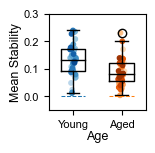

In [44]:
''' Plot Within Map Stability across Age Groups (Figure 5G) '''

labels = ['Young','Aged']
w = 0.5

fig, ax = plt.subplots(1, 1, figsize=(1.25, 1.25), sharey = True)
#fig.suptitle('Spatial Cell Within Map Stability, Pooled by Age Group', fontsize=12)

slocstab5_tog = [slocstab5[y_sind99],slocstab5[age_sind99]]
ax.boxplot(slocstab5_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.hlines(np.mean(sshuflocstab5[y_sind99]), 0.75, 1.25, color = 'C0', linestyle ='dashed', linewidth = 0.75, label = 'Young Shuffle')
ax.hlines(np.mean(sshuflocstab5[age_sind99]), 1.75, 2.25, color = 'C1', linestyle ='dashed', linewidth = 0.75, label = 'Aged Shuffle')
#ax.set_title('Session Spatial Cell Within Map Stability k = 5', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Stability', fontsize=9, labelpad=1)

for i in range(len(slocstab5_tog)):
    y = slocstab5_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax.scatter(x, y, color = col_session99[i], edgecolors = col_session99[i], alpha = 1, s = 10)

ax.set_ylim([-0.05,0.3])
ax.set_yticks([0,0.1,0.2,0.3])
ax.tick_params(labelsize = 8)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + '5G.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '5G.svg', dpi=400, bbox_inches='tight')
plt.show()

In [45]:
''' Statistics on Mean locstab5 '''

print('\nWithin Map locstab5 Young vs. Aged RESULTS:')
print('locstabyoung ± SEM; locstab_old ± SEM')
print(str(np.round(np.mean(slocstab5[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(slocstab5[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(slocstab5[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(slocstab5[age_sind99]), 4)))

stat, p_diff = stats.ranksums(slocstab5[y_sind99],slocstab5[age_sind99])
print('stat = ' + str(stat))
print('p_session, locstab5 = ' + str(p_diff))

print('\nWithin Map locstab5 Shuffle Young vs. Aged RESULTS:')
print('shuflocstabyoung ± SEM; shuflocstab_old ± SEM')
print(str(np.round(np.mean(sshuflocstab5[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshuflocstab5[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sshuflocstab5[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshuflocstab5[age_sind99]), 4)))

stat, p_diff = stats.ranksums(sshuflocstab5[y_sind99],sshuflocstab5[age_sind99])
print('stat = ' + str(stat))
print('p_session, shuff locstab5 = ' + str(p_diff))

print('\nYoung Shuffle vs. Real Results:')
print('shufflocstab5SC_young ± SEM, locstab5SC_young ± SEM')
print(str(np.round(np.mean(sshuflocstab5[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshuflocstab5[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(slocstab5[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(slocstab5[y_sind99]), 4)))

stat, p_diff = stats.wilcoxon(sshuflocstab5[y_sind99],slocstab5[y_sind99])
print('stat = ' + str(stat))
print('p_session, P99 locstab5 = ' + str(p_diff))

print('\nAged Shuffle vs. Real Results:')
print('shufflocstab5SC_old ± SEM, locstab5SC_old ± SEM')
print(str(np.round(np.mean(sshuflocstab5[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshuflocstab5[age_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(slocstab5[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(slocstab5[age_sind99]), 4)))

stat, p_diff = stats.wilcoxon(sshuflocstab5[age_sind99],slocstab5[age_sind99])
print('stat = ' + str(stat))
print('p_session, P99 locstab5 = ' + str(p_diff))

print('\nn young, aged sessions:')
print(len(y_sind99), len(age_sind99))


Within Map locstab5 Young vs. Aged RESULTS:
locstabyoung ± SEM; locstab_old ± SEM
0.1315 ± 0.0087 ; 0.0895 ± 0.0075
stat = 3.647796658112309
p_session, locstab5 = 0.0002644988343191263

Within Map locstab5 Shuffle Young vs. Aged RESULTS:
shuflocstabyoung ± SEM; shuflocstab_old ± SEM
0.0009 ± 0.0002 ; 0.001 ± 0.0003
stat = -0.026369614395992596
p_session, shuff locstab5 = 0.9789625299178463

Young Shuffle vs. Real Results:
shufflocstab5SC_young ± SEM, locstab5SC_young ± SEM
0.0009 ± 0.0002 ; 0.1315 ± 0.0087
stat = 0.0
p_session, P99 locstab5 = 2.2737367544323206e-13

Aged Shuffle vs. Real Results:
shufflocstab5SC_old ± SEM, locstab5SC_old ± SEM
0.001 ± 0.0003 ; 0.0895 ± 0.0075
stat = 0.0
p_session, P99 locstab5 = 4.547473508864641e-13

n young, aged sessions:
43 42


C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     Stab     
No. Observations:       8476        Method:                 REML     
No. Groups:             16          Scale:                  0.0045   
Min. group size:        7           Log-Likelihood:         4827.6752
Max. group size:        1100        Converged:              Yes      
Mean group size:        529.8                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.138    0.018  7.656 0.000  0.102  0.173
C(AgeGroup)[T.3.0]         -0.026    0.021 -1.274 0.203 -0.066  0.014
C(Sex)[T.M]                 0.014    0.019  0.723 0.469 -0.024  0.052
Session                    -0.003    0.001 -2.091 0.037 -0.005 -0.000
Session:C(AgeGroup)[T.3.0] -0.001   

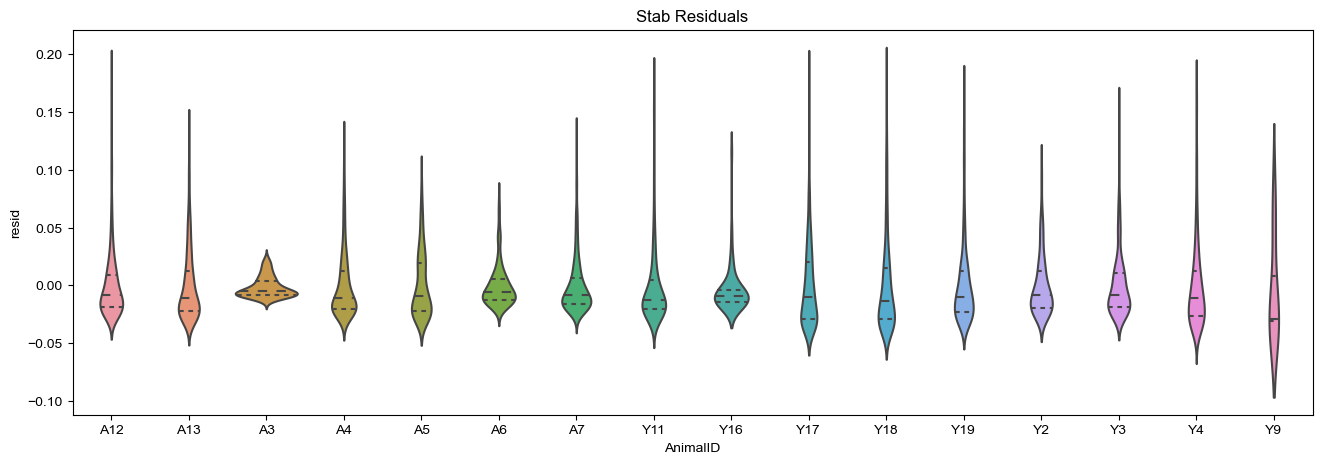

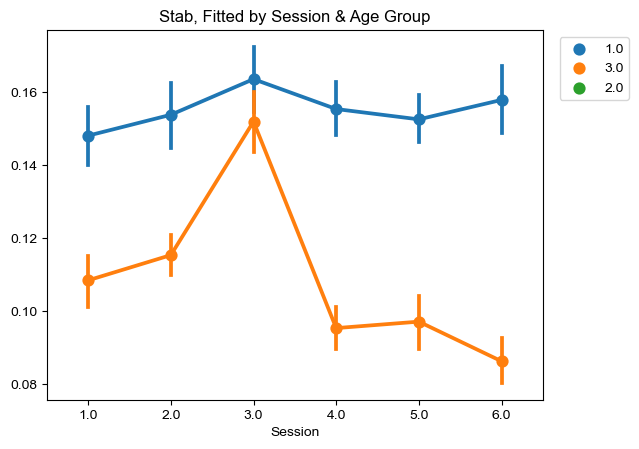

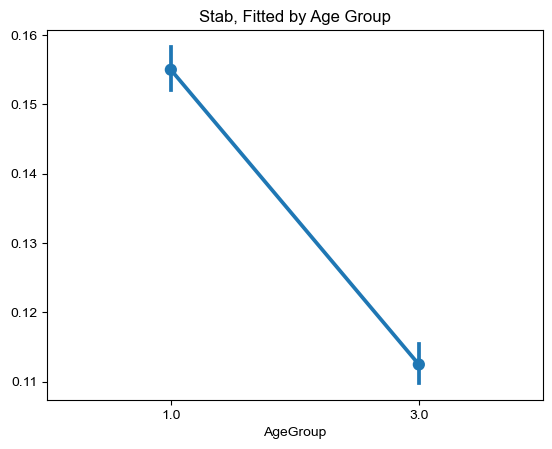

Raw Data Mean across All Sessions by Animal:
AnimalID
A12    0.123181
A13    0.139753
A3     0.033406
A4     0.110256
A5     0.131193
A6     0.076544
A7     0.093754
Y11    0.121135
Y16    0.066790
Y17    0.164919
Y18    0.171850
Y19    0.150398
Y2     0.112479
Y3     0.129535
Y4     0.179697
Y9     0.121818

Fitted Data Mean across All Sessions by Animal:
AnimalID
A12    0.123128
A13    0.139645
A3     0.034743
A4     0.110164
A5     0.130807
A6     0.076806
A7     0.093775
Y11    0.121261
Y16    0.070809
Y17    0.164817
Y18    0.171753
Y19    0.150359
Y2     0.112850
Y3     0.129523
Y4     0.179469
Y9     0.126400


In [45]:
''' Run LMM on Within Map Stability, Report out Fitted Values for Figure 7 '''

#gather dependent variables into lists
Stab = list(np.concatenate((alocstab5,ylocstab5)))

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, Stab))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID', 'Sex', 'AgeGroup','Cohort','Stab'])

#handle NaNs
df = df.dropna()

# Stab  Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mstab = smf.mixedlm('Stab ~ 1 + C(AgeGroup) + C(Sex) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml = True)
print(mstab.summary())
print(mstab.wald_test_terms(scalar = False))
#print(mstab.aic)
#print(mstab.bic)

#plots of residuals
df['resid'] = mstab.resid
fig, ax = plt.subplots(figsize = (16,5))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Stab Residuals')
plt.show()

#plot fitted values
hue_order = [1.0, 3.0, 2.0]
sns.pointplot(x = df['Session'], y = mstab.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Stab, Fitted by Session & Age Group')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

sns.pointplot(x = df['AgeGroup'], y = mstab.fittedvalues)
plt.title('Stab, Fitted by Age Group')
plt.show()

df['fitted'] = mstab.fittedvalues
animalgrouped = df.groupby(['AnimalID'])

print('Raw Data Mean across All Sessions by Animal:')
print(animalgrouped['Stab'].mean().to_string(index=True))

print('\nFitted Data Mean across All Sessions by Animal:')
print(animalgrouped['fitted'].mean().to_string(index=True))

# No sig. session x age effects... Therefore, not reporting change in mean across sessions
#print('\nFitted Data Mean across All Sessions by Animal:')
#print('First Three: ')
#print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))
#print('Last Three: ')
#print(df.loc[df['Session'] >= 4].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))

# Compare position decoding accuracy from young vs. aged spatial network activity for sessions with optimal k = 2 (Figure 5H - J)

In [24]:
''' Compute & Save Start & Stop Indices Corresponding to End of Dark, Start of Gain Periods'''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02

for m, session in zip(mice,sessions):
        
    if m in cohortb_mice:
        max_trials = 240
    else:
        max_trials = 200
        
    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = max_trials)
            
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 1, 1)
            #print(m, s)
        else:
            alltrial = np.arange(0,max_trials,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        
        #count number of skipped dark trials
        ndarkskipped = 0
        for z in skippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, skippedtrials)
            
        #define random foraging trials only, excluding dark & gain change periods
        if m == 'Y9':
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
        elif m in cohortb_mice:
            start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
            end_idx = (np.where(skippedrawtrialfil >= 220)[0][0]).astype(int)
        else:
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
            
        d['start'] = start_idx
        d['end'] = end_idx

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [25]:
'''For k = 2 sessions, get map indices for each observation'''
for m, session in zip(mice, sessions):
    
    if m in cohortb_mice:
        max_trials = 240
    else:
        max_trials = 200
        
    for s in session:
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = max_trials)
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 1, 1)
        else:
            alltrial = np.arange(0,max_trials,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        
        #count number of skipped dark trials
        ndarkskipped = 0
        for z in skippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, skippedtrials)
            
        start = d['start']
        end = d['end']
        d['skippedrawtrialfil'] = skippedrawtrialfil
    
        if len(spatialcells) > 10:
        
            if d['kmeans']['onemap'][0].astype(bool) == False:
                
                if d['kmeans']['SilN'] == 2:
                    d['2map'] = 1

                    W = d['kmeans']['W']
                    map0 = d['map0_idx']
                    map_idx = W[:, map0].astype(bool)
                    trials = skippedrawtrialfil[start:end]

                    map0_idx = np.zeros_like(trials)
                    map1_idx = np.zeros_like(trials)
                    for i, t in enumerate(np.unique(trials)):
                        if map_idx[i]:
                            map0_idx[trials == t] = 1
                        else:
                            map1_idx[trials == t] = 1

                    map0_idx = map0_idx.astype(bool)
                    map1_idx = map1_idx.astype(bool)
                    d['idx'] = np.row_stack((map0_idx, map1_idx))
                else:
                    d['2map'] = 0
            else:
                d['2map'] = 0      
        else:
            d['2map'] = 0

In [49]:
''' DECODER ANALYSIS '''
import scipy.stats 
from scipy.ndimage import gaussian_filter1d
normcdf = scipy.stats.norm.cdf
normpdf = scipy.stats.norm.pdf

SMOOTHNESS = 10.0
REGULARIZATION = 1e-4

## REGRESSION MODEL ##

from scipy.linalg import cho_factor, cho_solve
from sklearn.base import BaseEstimator

class CircularRegression(BaseEstimator):
    
    def __init__(self, alpha=0.0, tol=1e-5, max_iter=100):
        self.alpha = alpha
        self.tol = tol
        self.max_iter = max_iter
    
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array
            Independent variables, has shape (n_timepoints x n_neurons)
        y : array
            Circular dependent variable, has shape (n_timepoints x 1),
            all data should lie on the interval [-pi, +pi].
        """
        
        # Convert 1d circular variable to 2d representation
        u = np.column_stack([np.sin(y), np.cos(y)])

        # Randomly initialize weights. Ensure scaling does
        W = np.random.randn(X.shape[1], 2)
        W /= np.max(np.sum(np.abs(X @ W), axis=1))
        
        # Cache neuron x neuron gram matrix. This is used below
        # in the M-step to solve a linear least squares problem
        # in the form inv(XtX) @ XtY. Add regularization term to
        # the diagonal.
        XtX = X.T @ X
        XtX[np.diag_indices_from(XtX)] += self.alpha
        XtX = cho_factor(XtX)

        # Compute model prediction in 2d space, and projection onto
        # each observed u.
        XW = (X @ W)
        t = np.sum(u * XW, axis=1)
        tcdf = normcdf(t)
        tpdf = normpdf(t)

        self.log_like_hist_ = [
            np.log(2 * np.pi) - 
            0.5 * np.mean(np.sum(XW * XW, axis=1), axis=0) +
            np.mean(np.log(1 + t * tcdf / tpdf))
        ]

        for itr in range(self.max_iter):

            # E-step.
            m = t + (tcdf / ((tpdf + t * tcdf)))
            XtY = X.T @ (m[:, None] * u)

            # M-step.
            W = cho_solve(XtX, XtY)
            
            # Recompute model prediction.
            XW = X @ W
            t = np.sum(u * XW, axis=1)
            tcdf = normcdf(t)
            tpdf = normpdf(t)

            # Store log-likelihood.
            self.log_like_hist_.append(
                np.log(2 * np.pi) - 
                0.5 * np.mean(np.sum(XW * XW, axis=1), axis=0) +
                np.mean(np.log(1 + t * tcdf / tpdf))
            )
            
            # Check convergence.
            if (self.log_like_hist_[-1] - self.log_like_hist_[-2]) < self.tol:
                break
    
        self.weights_ = W
    
    def predict(self, X):
        u_pred = X @ self.weights_
        return np.arctan2(u_pred[:, 0], u_pred[:, 1])

    def score(self, X, y):
        """
        Returns 1 minus mean angular similarity between y and model prediction.
        
        score == 1 for perfect prediction
        score == 0 in expectation for random prediction
        score == -1 if prediction is off by 180 degrees.
        """
        y_pred = self.predict(X)
        return np.mean(np.cos(y - y_pred))

In [50]:
''' Get X (instantaneous FR) and y (circular position) for only VR ON & regular gain periods '''

dt = 0.02
track_len = 400

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]

        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-errorcorrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        start = d['start']
        end = d['end']
        
        # convert spikes to instantaneous FR and smooth
        X = Y[start:end,:] / dt # convert spike count to FR
        X = gaussian_filter1d(X, SMOOTHNESS, axis=0)
        
        # format position s.t. 0 = -pi = +pi = 400
        y_raw = behaviorfil[:, 0][start:end]
        y = (y_raw / np.max(y_raw)) * 2 * np.pi - np.pi
        
        d['X'] = X
        d['y'] = y

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [53]:
''' Downsample to match speed and num observations '''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-errorcorrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell99]
        
        start = d['start']
        end = d['end']
        
        speed = behaviorfil[:, 1][start:end]
        y = d['y']
        
        if d['2map'] == 1: 
            map0_idx = d['idx'][0, :]
            map1_idx = d['idx'][1, :]

            # bin speed into 10cm/s bins
            edges = np.arange(10, np.max(speed), 10)
            speed_idx = np.digitize(speed, edges)

            # get indices for each map's observations
            all_obs = np.arange(y.shape[0])
            obs_0 = np.arange(y.shape[0])[map0_idx]
            obs_1 = np.arange(y.shape[0])[map1_idx]

            # array to hold indices for downsampling
            ds_all = np.asarray([]) # array to hold indices for downsampling all trials
            ds_0 = np.asarray([]) # array to hold indices for downsampling map 0
            ds_1 = np.asarray([]) # array to hold indices for downsampling map 1

            # match occupancy of each bin for each map
            bins, ct = np.unique(speed_idx, return_counts=True)
            for b in bins:
                occupancy_0 = np.sum(map0_idx[speed_idx == b])
                occupancy_1 = np.sum(map1_idx[speed_idx == b])
                occupancy_all = np.sum(ct[b])    
                idx_0 = np.where(map0_idx & (speed_idx == b))[0]
                idx_1 = np.where(map1_idx & (speed_idx == b))[0]

                if occupancy_0 == occupancy_1:
                    ds_all = np.append(ds_all, np.random.choice(all_obs[speed_idx == b], occupancy_0, replace=False))
                elif occupancy_0 > occupancy_1:
                    # need to downsample map 0 for this speed bin
                    n_timepts = occupancy_1        
                    ds_all = np.append(ds_all, np.random.choice(all_obs[speed_idx == b], n_timepts, replace=False))
                    ds_0 = np.append(ds_0, np.random.choice(idx_0, n_timepts, replace=False))
                    ds_1 = np.append(ds_1, idx_1)
                else:
                    # need to downsample map 1 for this speed bin
                    n_timepts = occupancy_0
                    ds_all = np.append(ds_all, np.random.choice(all_obs[speed_idx == b], n_timepts, replace=False))
                    ds_0 = np.append(ds_0, idx_0)
                    ds_1 = np.append(ds_1, np.random.choice(idx_1, n_timepts, replace=False)) 
            ds_all = ds_all.astype(int)
            ds_0 = ds_0.astype(int)
            ds_1 = ds_1.astype(int)

            d['ds_idx'] = np.row_stack((ds_0, ds_1, ds_all))

In [54]:
''' Get shuffled spikes'''

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell99]
        
        ##Generate shuffled spike train for spatial cells only
        #get stuff you will to shuffle & re-filter spike times
        sp = raw.item().get('sp')
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        rawposx = raw.item().get('posx')
        rawpost = raw.item().get('post')
        rawspeed = raw.item().get('speed')
        
        dt = np.unique(np.round(np.diff(rawpost),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(rawpost) == 0)[0]
        else:
            dt_to_trash = [] 

        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        speed_to_trash = get.find(rawspeed < 2)
        pos_to_trash = get.find((rawposx < 0) | (rawposx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(len(rawspeed)), trash_idx)
        
        B = np.zeros((len(rawspeed), len(cell_IDs))) # reset empty shuffled FR matrix   
        for i, c in enumerate(cell_IDs):
            #get actual spike times for each cell
            st = spiket[cluster_id == c]
            st = st[(st >= min(rawpost)) & (st <= max(rawpost))]

            #get shuffle times
            st_shuf = st - min(rawpost)
            total_time = max(rawpost) - min(rawpost)
            add = np.random.uniform(0.02,total_time,1)
            st_shuf = (st_shuf + add) % total_time
            st_shuf = st_shuf + min(rawpost)

            #get unfiltered spike train
            spike_ct = np.zeros_like(rawpost)
            spike_idx = np.digitize(st_shuf, rawpost) #obs corresponding to where each shuffled spike occurs

            idx, cts = np.unique(spike_idx, return_counts = True)
            spike_ct[idx] = cts
            B[:,i] = spike_ct

            #check for & interpolate any missing values
            if sum(np.isnan(B[:,i])) > 0:
                B[:,i] = get.nan_interp(B[:,i])  

        #apply filter spike train by speed, dt, & posx errors
        B = B[keep_idx,:]
        shuff_X = B / dt # convert spike count to FR
        shuff_X = gaussian_filter1d(shuff_X, SMOOTHNESS, axis=0)
        d['shuff_X'] = shuff_X

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [55]:
'''Define Function to Split Train & Test Blocks'''

def train_vs_test_blocks(X, y, train_data_idx, test_data_idx, n_repeats=10, train_pct=0.9):
    test_scores = []    
    test_folds = np.array_split(test_data_idx, n_repeats)

    for i in range(n_repeats):        
        # Get train and test indices
        test_idx = test_folds[i]
        train_idx = np.random.choice(np.setdiff1d(train_data_idx, test_idx),
                                     replace=False, size=int(train_data_idx.size * train_pct))
        # Train model
        model.fit(X[train_idx], y[train_idx])

        # Compute test error
        test_scores.append(model.score(X[test_idx], y[test_idx]))
        
    return np.asarray(test_scores)

In [56]:
''' Fit model on the speed-matched spatial cell activity in each map or random selections from both maps from each session '''

model = CircularRegression(alpha=REGULARIZATION)

# cross-validate the model
for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell99]
        
        if d['2map'] == 1: 
            #restrict position decoding to spatial cell activity
            X = d['X']
            sdx = []
            for i, c in enumerate(spatialcells):
                sd = (np.where(cell_IDs == c)[0][0]).astype(int)
                sdx.append(sd)
            X = X[:,sdx]

            shuff_X = d['shuff_X']
            shuff_X = shuff_X[:,sdx]
            y = d['y']

            ds_0 = d['ds_idx'][0, :]
            ds_1 = d['ds_idx'][1, :]
            ds_all = d['ds_idx'][-1, :]

            # get CV scores for each train and test combo - save these!
            train0_test0_scores = train_vs_test_blocks(X, y, ds_0, ds_0)
            train0_test1_scores = train_vs_test_blocks(X, y, ds_0, ds_1)
            train1_test1_scores = train_vs_test_blocks(X, y, ds_1, ds_1)
            train1_test0_scores = train_vs_test_blocks(X, y, ds_1, ds_0)
            random_scores = train_vs_test_blocks(X, y, ds_all, ds_all)
            spatialscores = np.row_stack((train0_test0_scores, train0_test1_scores, 
                                        train1_test1_scores, train1_test0_scores, 
                                        random_scores))

            # get CV scores for each train and test combo - save these!
            train0_test0_scores = train_vs_test_blocks(shuff_X, y, ds_0, ds_0)
            train0_test1_scores = train_vs_test_blocks(shuff_X, y, ds_0, ds_1)
            train1_test1_scores = train_vs_test_blocks(shuff_X, y, ds_1, ds_1)
            train1_test0_scores = train_vs_test_blocks(shuff_X, y, ds_1, ds_0)
            random_scores = train_vs_test_blocks(shuff_X, y, ds_all, ds_all)
            spatialshuffscores = np.row_stack((train0_test0_scores, train0_test1_scores, 
                                        train1_test1_scores, train1_test0_scores, 
                                        random_scores))
            
            #save scores for all eligible sessions
            spatialscores_file = 'spatialscores_' + m + '_' + s + '.npy'
            spatialshuffscores_file = 'spatialshuffscores_' + m + '_' + s + '.npy'
            
            np.save(save_folder + spatialscores_file, spatialscores)
            np.save(save_folder + spatialshuffscores_file, spatialshuffscores)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
''' Load results of this analysis only for k = 2 cells '''

spatialscore = []
spatialshuffscore = []
morethan10spatial = []

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        spatialscores_file = 'spatialscores_' + m + '_' + s + '.npy'
        spatialshuffscores_file = 'spatialshuffscores_' + m + '_' + s + '.npy'

        if d['2map'] == 1:

            spatialscores  = np.load(save_folder + spatialscores_file)
            d['spatialscores'] = spatialscores

            spatialshuffscores = np.load(save_folder + spatialshuffscores_file)
            d['spatialshuffscores'] = spatialshuffscores
            
            spatialscores = d['spatialscores']
            spatialshuffscores = d['spatialshuffscores']

            morethan10spatial = np.append(morethan10spatial, True)
            spatialscore = np.append(spatialscore, np.mean(spatialscores, axis = 1)[-1])
            spatialshuffscore = np.append(spatialshuffscore, np.mean(spatialshuffscores, axis = 1)[-1])
            
        else:
            
            morethan10spatial = np.append(morethan10spatial, False)
            spatialscore = np.append(spatialscore, np.nan)
            spatialshuffscore = np.append(spatialshuffscore, np.nan)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [28]:
''' Find where I will have NaNs for Scores, Mean & Peak FR, Slope, Y-Int'''
nan_idx10spatial = np.where((morethan10spatial.astype(bool) == 0))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindspatial = np.setdiff1d(y_sind, nan_idx10spatial)
age_sindspatial = np.setdiff1d(age_sind, nan_idx10spatial)

# Adjust colormaps for spatial plots
yidx = []
aidx = []
for i in nan_idx10spatial:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_youngspatial = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_oldspatial = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessionspatial = [col_session_youngspatial, col_session_oldspatial] 

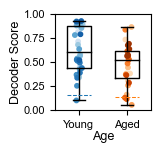

In [29]:
''' Plot Figure 5H '''

fig, ax = plt.subplots(figsize = (1.25,1.25))
labels = ['Young','Aged']
w = 0.5
sscore_tog = [spatialscore[y_sindspatial], spatialscore[age_sindspatial]]
ax.boxplot(sscore_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.hlines(np.mean(spatialshuffscore[y_sindspatial]), 0.75, 1.25, color = 'C0', linestyle ='dashed', linewidth = 0.75, label = 'Young Shuffle')
ax.hlines(np.mean(spatialshuffscore[age_sindspatial]), 1.75, 2.25, color = 'C1', linestyle ='dashed', linewidth = 0.75, label = 'Aged Shuffle')
ax.set_ylim([0,1])

for i in range(len(sscore_tog)):
    y = sscore_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax.scatter(x, y, color = col_sessionspatial[i], edgecolors = col_sessionspatial[i], alpha = 1, s = 10)
    
ax.set_ylabel('Decoder Score', fontsize = 9, labelpad = 1)
ax.set_xlabel('Age', fontsize = 9, labelpad = 1)
ax.set_ylim([0,1])
ax.tick_params(labelsize = 8)

plt.savefig(save_folder + '5H.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '5H.svg', dpi=400, bbox_inches='tight')
plt.show()

In [30]:
'''Statistics on Decoder Score'''

print('Real RESULTS:')
print('meandecoderscoreyoung ± SEM; meandecoderscore_old ± SEM')
print(str(np.round(np.nanmean(spatialscore[y_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialscore[y_sindspatial]), 4)) + ' ; ' 
      + str(np.round(np.nanmean(spatialscore[age_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialscore[age_sindspatial]), 4)))

stat, p_diff = stats.ranksums(spatialscore[y_sindspatial],spatialscore[age_sindspatial])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))
print('n young, aged RF sessions with k = 2: ')
print(len(y_sindspatial), len(age_sindspatial))

print('\nShuffle RESULTS:')
print('meandecoderscoreyoung ± SEM; meandecoderscore_old ± SEM')
print(str(np.round(np.nanmean(spatialshuffscore[y_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialshuffscore[y_sindspatial]), 4)) + ' ; ' 
      + str(np.round(np.nanmean(spatialshuffscore[age_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialshuffscore[age_sindspatial]), 4)))

stat, p_diff = stats.ranksums(spatialshuffscore[y_sindspatial],spatialshuffscore[age_sindspatial])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

print('\nDiff Shuffle vs. Real RESULTS Young:')
stat, p_diff = stats.wilcoxon(spatialscore[y_sindspatial],spatialshuffscore[y_sindspatial],alternative = 'greater')
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

print('\nDiff Shuffle vs. Real RESULTS Aged:')
stat, p_diff = stats.wilcoxon(spatialscore[age_sindspatial],spatialshuffscore[age_sindspatial],alternative = 'greater')
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

Real RESULTS:
meandecoderscoreyoung ± SEM; meandecoderscore_old ± SEM
0.6271 ± 0.0406 ; 0.4683 ± 0.0416
stat = 2.3377567180304726
p_session = 0.019399872048410535
n young, aged RF sessions with k = 2: 
34 27

Shuffle RESULTS:
meandecoderscoreyoung ± SEM; meandecoderscore_old ± SEM
0.1531 ± 0.0111 ; 0.1323 ± 0.0114
stat = 1.1906587011086878
p_session = 0.23378759696604667

Diff Shuffle vs. Real RESULTS Young:
stat = 595.0
p_session = 5.820766091346741e-11

Diff Shuffle vs. Real RESULTS Aged:
stat = 378.0
p_session = 7.450580596923828e-09


In [31]:
''' Correlate Spatial Cell Decoding Scores w/ Avg Spatial Cell Coherence & Moving Avg. Stability for a Given Session''' 
    
#Collect Session Avg. Spatial Cell Coherence & Stability
avgcoherence = []
avgstability = []

for m, session in zip(mice, sessions):

    for s in tdqm(session):
        d = data[m][s]
        
        if d['2map'] == 1:
            #load coherence scores (one for every cell)
            spatialcoherencescore_file = 'spatialcoherencescores_' + m + '_' + s + '.npy'
            spatialcoherencescores = np.load(save_folder + spatialcoherencescore_file, allow_pickle=True)

            #load the cross trial correlation matrices for all spatial cells  
            allsim_file = 'allsim_' + m + '_' + s + '_'+ '.npy'
            allsim  = np.load(save_folder + allsim_file)

            #load in data
            rawdata_file = 'RAW_' + m + '_' + s + '.npy'
            behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'

            raw = np.load(load_folder + rawdata_file, allow_pickle=True)
            behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

            cell_IDs = raw.item().get('cellsfil')
            spatialcell99 = d['spatialcell99'].astype(bool)
            spatialcells = cell_IDs[spatialcell99]

            within_map_stability_file = 'within_map_stab_' + m + '_' + s + '.npy'
            withinmapstab = np.load(save_folder + within_map_stability_file)

            coherencescores = []
            local_stability5 = withinmapstab
            for i, c in enumerate(spatialcells):
                sdx = (np.where(cell_IDs==c)[0][0]).astype(int)

                #get saved coherence score
                coherencescores = np.append(coherencescores, spatialcoherencescores[sdx])

            #save session average
            avgcoherence = np.append(avgcoherence, np.nanmean(coherencescores))
            avgstability = np.append(avgstability, np.nanmean(local_stability5))
            
        else:
            avgcoherence = np.append(avgcoherence, np.nan)
            avgstability = np.append(avgstability, np.nan)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]


Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, Aged, All]: 
0.5478146949516323 0.6563328582730029 0.9806687844640178
P [Young, MA, Aged, All]: 
0.0007977277920728761 0.00020105548925119978 1.6728756036951034e-43

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, Aged, All]: 
0.6663931424072107 0.7851857424932752 0.9779326865692527
P [Young, MA, Aged, All]: 
1.689051024855544e-05 1.23300572089287e-06 7.996303004495439e-42

n young, aged sessions:
34 27


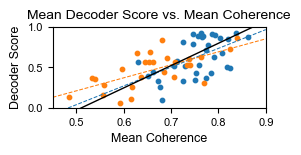

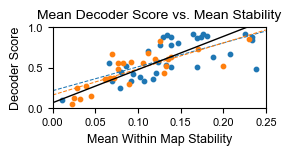

In [32]:
''' Plot Correlation of Mean Spatial Cell Decoder Score vs. Mean Coherence / Stability (Figure 5J)'''

#Linear regression
res = stats.linregress(avgcoherence[y_sindspatial],spatialscore[y_sindspatial])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(avgcoherence[age_sindspatial],spatialscore[age_sindspatial])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(np.union1d(avgcoherence[y_sindspatial],avgcoherence[age_sindspatial]),
                       np.union1d(spatialscore[y_sindspatial],spatialscore[age_sindspatial]))
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, Aged, All]: ')
print(yr1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, ap1, allp1)

res = stats.linregress(avgstability[y_sindspatial],spatialscore[y_sindspatial])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(avgstability[age_sindspatial],spatialscore[age_sindspatial])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue; ap2 = res.pvalue

res = stats.linregress(np.union1d(avgstability[y_sindspatial],avgstability[age_sindspatial]),
                       np.union1d(spatialscore[y_sindspatial],spatialscore[age_sindspatial]))
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, Aged, All]: ')
print(yr2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, ap2, allp2)

print('\nn young, aged sessions:')
print(len(y_sindspatial), len(age_sindspatial))

#Plot Figure 5J (left)
fig, ax = plt.subplots(figsize = (2.75,1.05))
ax.set_title('Mean Decoder Score vs. Mean Coherence', fontsize = 10)
ax.scatter(avgcoherence[y_sindspatial],spatialscore[y_sindspatial], color = 'C0', label = 'Young', s = 10)
ax.scatter(avgcoherence[age_sindspatial],spatialscore[age_sindspatial], color = 'C1', label = 'Aged', s = 10)
ax.set_xlabel('Mean Coherence', fontsize = 9)
ax.set_ylabel('Decoder Score', fontsize = 9)
ax.set_xlim([0.45,0.9])
ax.set_ylim([0,1])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope1*X_plot + yint1, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
ax.plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + '5Jleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '5Jleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#Plot Figure 5J (right)
fig, ax = plt.subplots(figsize = (2.75,1.05))
ax.set_title('Mean Decoder Score vs. Mean Stability', fontsize = 10)
ax.scatter(avgstability[y_sindspatial],spatialscore[y_sindspatial], color = 'C0', label = 'Young', s = 10)
ax.scatter(avgstability[age_sindspatial],spatialscore[age_sindspatial], color = 'C1', label = 'Aged', s = 10)
ax.set_xlabel('Mean Within Map Stability', fontsize = 9)
ax.set_ylabel('Decoder Score', fontsize = 9)
ax.set_xlim([0,0.25])
ax.set_ylim([0,1])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '--', color = 'C0', linewidth = 0.75, label = 'Young Fit')
ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
plt.savefig(save_folder + '5Jright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '5Jright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

Mean Age Group Score = 0.4742594647865832
Mean score on all test data this run = 0.44092357077943406
Score on the test trial to be plotted below = 0.4687447775151779


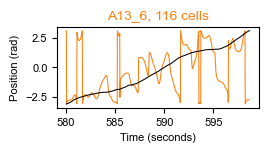

Mean Age Group Score = 0.6408452009592848
Mean score on all test data this run = 0.5337184648397472
Score on the test trial to be plotted below = 0.6583547706548788


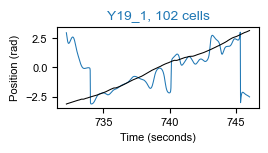

In [64]:
''' Visualize decoding on 1st test trial from representative sessions (Plot Example like in Figure 5I) 

Please note: this will never match Figure 5I exactly because that the result here is based on a random train/test set. 

You can rerun this repeatedly to keep generating new example plots from these same sessions.

'''
model = CircularRegression(alpha=REGULARIZATION)
refscores = [np.mean(spatialscore[y_sindspatial]),np.mean(spatialscore[age_sindspatial])]

colors = ['C0','C1']

# most representative mice of age group averages; Y19_1 has optimal k = 2, A13_6 has optimal k = 4 
ex_mice = ['Y19','A13']
ex_sessions = ['062822_record1','051022_record6']

# to check out Y18, A12 sessions also represented in Figure 5A, which have optimal k = 2:
#ex_mice = ['Y18','A12']
#ex_sessions = ['062022_record1','052022_record3']

for m, session in zip(mice, sessions):
    for s in session:
        
        if (m not in ex_mice) or (s not in ex_sessions):
            continue
        
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell99]
        
        #restrict position decoding to spatial cell activity
        X = d['X']
        sdx = []
        for i, c in enumerate(spatialcells):
            sd = (np.where(cell_IDs == c)[0][0]).astype(int)
            sdx.append(sd)
        X = X[:,sdx]
        
        # randomly split all trials into training vs. test sets & identify their indices
        start = d['start']
        end = d['end']
        y = d['y']
        
        trial = behaviorfil[:,2]
        trial = trial[start:end]
        post = behaviorfil[:,3][start:end]
        trials = np.unique(trial)

        train_trials = np.random.choice(trials, replace = False, size = 9*len(trials)//10)
        test_trials = np.setdiff1d(trials, train_trials)

        train_data = []
        for t in train_trials:
            idx = np.where(trial == t)[0].astype(int)
            train_data = np.append(train_data, idx)

        #select test trial idx
        test_data = []
        for t in test_trials:
            idx = np.where(trial == t)[0].astype(int)
            test_data = np.append(test_data, idx)
            
        train_data = train_data.astype(int)
        test_data = test_data.astype(int)

        # get model predictions & performance on entire test set when trained on entire training set.
        model.fit(X[train_data,:], y[train_data])
        predy = model.predict(X[test_data,:])
        score = model.score(X[test_data,:], y[test_data])
        realy = y[test_data]
        
        #find trial with score closest to average cross validated decoder score for plotting
        trialscores = []
        #refscore = np.mean(d['spatialscores'], axis = 1)[-1]
        
        if m in all_young_mice:
            refscore = refscores[0]
        else:
            refscore = refscores[1] 
            
        for t in test_trials:
            idx = np.where(trial == t)[0].astype(int)
            trialscores = np.append(trialscores, model.score(X[idx,:], y[idx]))
        
        avgtrial = test_trials[np.argmin(np.abs(trialscores - refscore))]
        avgtrialscore = trialscores[np.argmin(np.abs(trialscores - refscore))]
        avgtrialidx = np.where(trial == avgtrial)[0].astype(int)
        avgtestrialidxstart = np.where(test_data == avgtrialidx[0])[0][0]
        avgtestrialidxend = np.where(test_data == avgtrialidx[-1])[0][0] + 1
        
        #Compare performance on this run to CV average
        print('Mean Age Group Score = ' + str(refscore))
        print('Mean score on all test data this run = ' + str(score))
        print('Score on the test trial to be plotted below = ' + str(avgtrialscore))
       
        if m in RF_aged_mice:
            #aged plot (Figure 5I bottom)
            fig, ax = plt.subplots(figsize = (2.6,1.05))
            ax.plot(post[avgtrialidx],predy[avgtestrialidxstart:avgtestrialidxend], color = colors[1], linewidth = 0.75, label = 'predicted')
            ax.plot(post[avgtrialidx],realy[avgtestrialidxstart:avgtestrialidxend], color = 'k', linewidth = 0.75, label = 'actual')
            ax.set_xlabel('Time (seconds)', fontsize = 8)
            ax.set_ylabel('Position (rad)', fontsize = 8)
            #ax.legend(fontsize = 8, bbox_to_anchor = (1.4,1))
            ax.tick_params(labelsize = 8)
            ax.set_title(str(m) + '_' + str(s[-1]) + ', ' + str(len(spatialcells)) + ' cells', fontsize = 10, color = 'C1')
            plt.savefig(save_folder + '5Ibottom.png', dpi=400, bbox_inches='tight')
            plt.savefig(save_folder + '5Ibottom.svg', dpi=400, bbox_inches='tight')
            plt.show()
            
        else:
            #young plot (Figure 5I top)
            fig, ax = plt.subplots(figsize = (2.6,1.05))
            ax.plot(post[avgtrialidx],predy[avgtestrialidxstart:avgtestrialidxend], color = colors[0], linewidth = 0.75, label = 'predicted')
            ax.plot(post[avgtrialidx],realy[avgtestrialidxstart:avgtestrialidxend], color = 'k', linewidth = 0.75, label = 'actual')
            ax.set_xlabel('Time (seconds)', fontsize = 8)
            ax.set_ylabel('Position (rad)', fontsize = 8)
            #ax.legend(fontsize = 8, bbox_to_anchor = (1.4,1))
            ax.tick_params(labelsize = 8)
            ax.set_title(str(m) + '_' + str(s[-1]) + ', ' + str(len(spatialcells)) + ' cells', fontsize = 10, color = 'C0')
            plt.savefig(save_folder + '5Itop.png', dpi=400, bbox_inches='tight')
            plt.savefig(save_folder + '5Itop.svg', dpi=400, bbox_inches='tight')
            plt.show()
